BART Performance Profiling
==========================

This notebook plots performance data collected by my [instrumented fork of BART](https://github.com/mbdriscoll/bart/tree/profiling) ([diff](https://github.com/mrirecon/bart/compare/master...mbdriscoll:profiling)).

## Experiment Conditions
  
We profiled BART on a 16-core SandyBridge machine (released 2012) ([full specs](https://gist.github.com/mbdriscoll/1064d5f9e8e077a2a5ae16c2a60eb677)).

We measured the performance of major operations in `pics` on tasks representing the cross product of:

*  **Dimensionalities**: 2D and 3D scans.
*  **Trajectories**: Cartesian or radial.
*  **Regularization methods**: L2, L1 Wavelet, L1 Total Variation.
*  **Problem sizes**: 32^2 to 512^3.

The full scripts used to generate test cases can be found [on Github](https://gist.github.com/mbdriscoll/64173e1c78b0300bd664a5991619a054).

## Jump to results:

*  [Time Breakdown vs. Problem Size](#Time-Breakdown-vs.-Problem-Size)
*  [Single-Iteration Operator Hierarchy](#Single-Iteration-Operator-Hierarchy)

## Setup Code

In [1]:
%matplotlib inline

import re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tabulate import tabulate
from frozendict import frozendict
from collections import defaultdict
from matplotlib.ticker import FuncFormatter
from IPython.core.display import HTML, display

In [2]:
class Event(object):
    def __init__(self, name, start=None, end=None):
        self.name = name
        self._start, self._end = start, end
        self.parent, self.children = None, []

    def add_child(self, child):
        self.children.append(child)
        child.parent = self
        
    def __getitem__(self, key):
        if isinstance(key, slice):
            evt = Event(self.name)
            for child in self.children[key]:
                evt.add_child(child)
            return evt
        else:
            return self.children[key]
        
    duration = property(lambda self: self.end - self.start)
    depth    = property(lambda self: 1 + (self.parent.depth if self.parent else 0))
    start    = property(lambda self: self._start or min(child.start for child in self.children))
    end      = property(lambda self: self._end   or max(child.end   for child in self.children))
    
    
iter_pattern = re.compile('((^(s|e).*\n)*#.*\n)', re.MULTILINE)
event_pattern = re.compile('(?P<event>\w+) (?P<op>\w+) (?P<time>\d+.\d+)')

def parse_log(log):   
    root = Event("<root>")
    for i, match in enumerate(re.findall(iter_pattern, log)):
        data = re.findall(event_pattern, match[0])
        tree = Event("<iter%02d>" % i)
        stack = [tree]
        for event, name, time in data:
            time = float(time)
            if event == 's':
                evt = Event(name, start=time)
                stack[-1].add_child(evt)
                stack.append(evt)
            elif event == 'e':
                evt = stack.pop()
                assert name == evt.name, name + evt.name
                evt._end = time
        root.add_child(tree)                        
    return root

data = dict()
fname_pattern = re.compile('profile_(?P<reg>\w+)_(?P<traj>\w+)_(?P<encodes>\w+)_d(?P<dims>\d+).log')
for logfile in sorted(glob.glob("profile*.log")):
    params = re.match(fname_pattern, logfile).groupdict()
    params['encodes'] = tuple(int(d) for d in params['encodes'].split('x'))
    params['dims'] = int(params['dims'])
    key = frozendict( params )
    with open(logfile, 'r') as log:
        data[key] = parse_log(log.read())

rows = []
def parse(data, params):
    times = defaultdict(float)
    duration = data.duration
    stack = [data]
    while stack:
        evt = stack.pop()
        stack.extend(evt.children)
        if not evt.children:
            times[evt.name] += evt.duration/data.duration
    times_sorted = sorted(times.items(), key=lambda kv: -kv[1])
    unaccounted = 1.0 - sum(v for k,v in times_sorted)
    times_sorted.append(("unaccounted", unaccounted))
    for op, fraction in times_sorted:
        rows.append(dict(params, op=op, iter_duration=data.duration, fraction=fraction))
        
for i, (params, run) in enumerate(data.items()):
    try: 
        parse(run, params)
    except (IndexError, ValueError) as e:
        print "FAIL case: %s, reason: %s" % (params, e)

df = pd.DataFrame(rows)
df["reg"] = df["reg"].astype("category")
df["traj"] = df["traj"].astype("category")
df["op"] = df["op"].astype("category")
df['nelems'] = df.encodes.map(lambda x: np.prod(x))
#df.tail()

FAIL case: <frozendict {'dims': 3, 'reg': 'tv', 'encodes': (512, 512, 512), 'traj': 'cart'}>, reason: max() arg is an empty sequence
FAIL case: <frozendict {'dims': 2, 'reg': 'l2', 'encodes': (32768, 4096), 'traj': 'radial'}>, reason: max() arg is an empty sequence


# Time Breakdown vs. Problem Size

This analysis reveals the most expensive operators/operations.

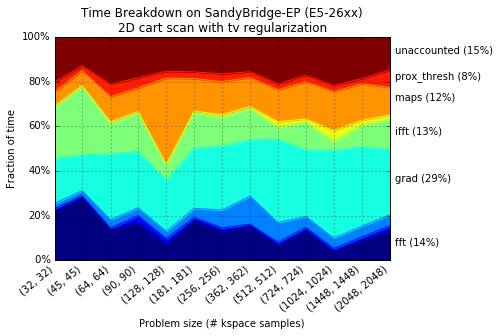

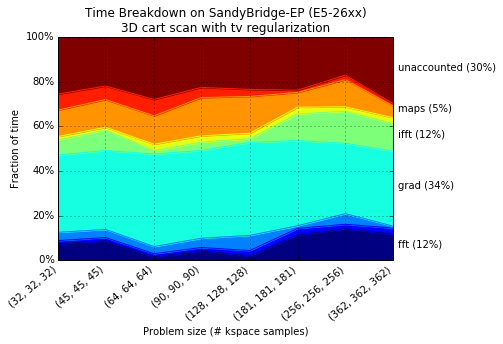

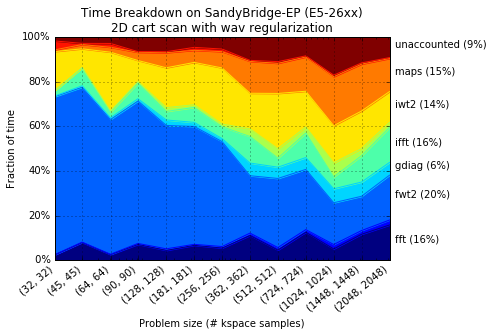

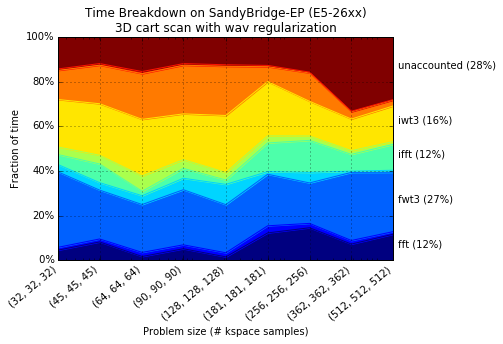

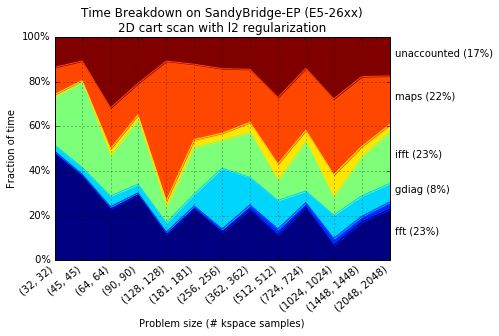

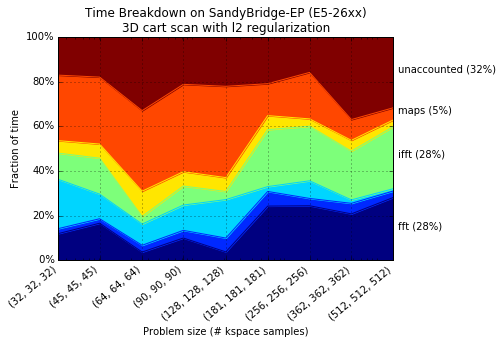

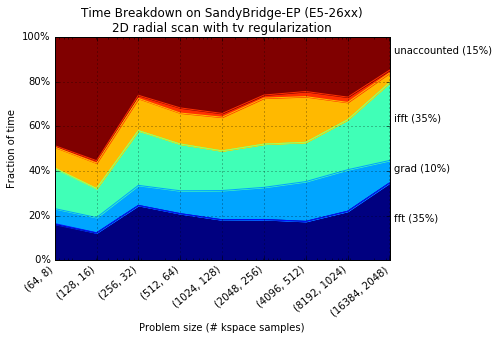

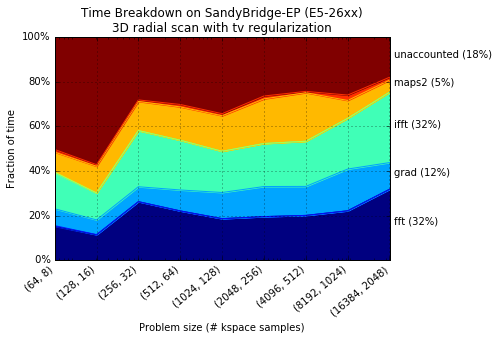

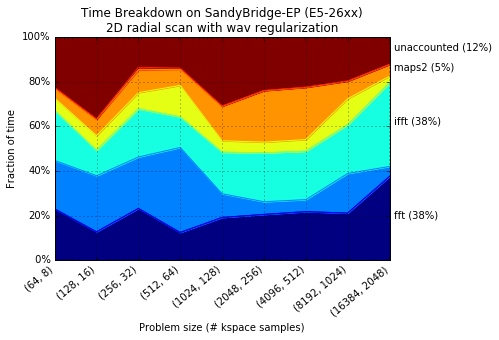

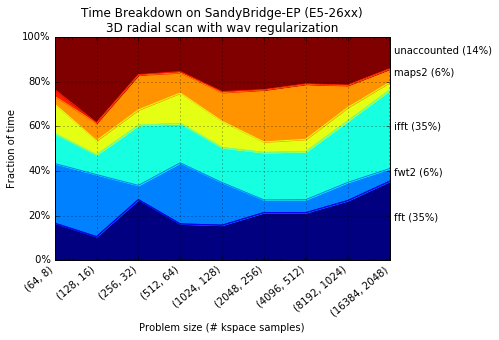

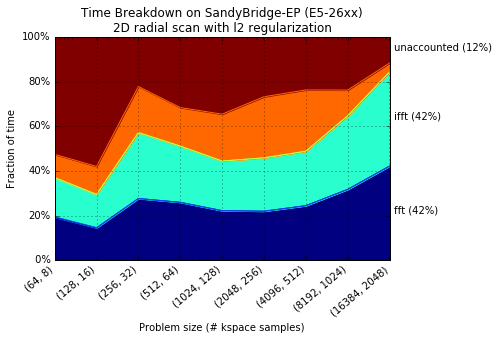

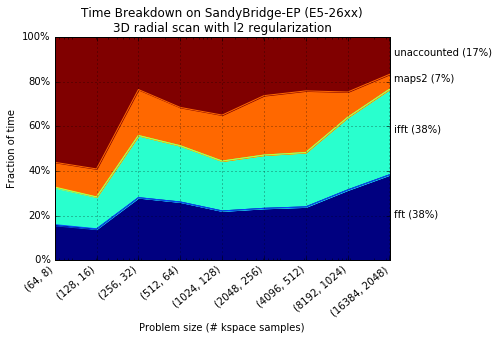

In [3]:
for t in df['traj'].unique():
    for r in df['reg'].unique():
        for d in df['dims'].unique():
            subset = df[(df.traj==t)&(df.reg==r)&(df.dims==d)]
            table = defaultdict(list)
            for op, fracs in subset.sort_values(by=['nelems']).groupby('op')['fraction']:
                if len(fracs):
                    table[op] = np.array(fracs)
            index = subset.sort_values(by=['nelems'])['nelems'].unique()
            sizes = subset.sort_values(by=['nelems'])['encodes'].unique()
            table = pd.DataFrame(table, index=index)

            fig = plt.figure()
            ax = fig.add_subplot(111)
            table.plot(ax=ax, kind='area', logx=True, grid=True, legend=False, ylim=(0,1), cmap='jet',
                title="Time Breakdown on SandyBridge-EP (E5-26xx)\n%sD %s scan with %s regularization" % (d, t, r))
            ax.set_xticks(index)
            ax.set_xticklabels(sizes, rotation=40, ha='right')
            ax.set_xlabel("Problem size (# kspace samples)")
            ax.set_ylabel("Fraction of time")
            ax.yaxis.set_major_formatter( FuncFormatter(lambda x,p: "%2.0f%%" % (x*100)) )
            
            lastrow = table.iloc[-1]
            starts = np.hstack([[0], lastrow.cumsum()])
            midpoints = (starts[1:] + starts[:-1]) / 2
            for name, value, y in zip(table.columns.values, lastrow, midpoints):
                if value >= 0.05:
                    label = "%s (%.f%%)" % (name, value*100)
                    ax.annotate(label, xy=(lastrow.name,y), xytext=(5,0), textcoords='offset points')

# Single-Iteration Operator Hierarchy

This analysis plots the series of operators invoked during a single iteration.

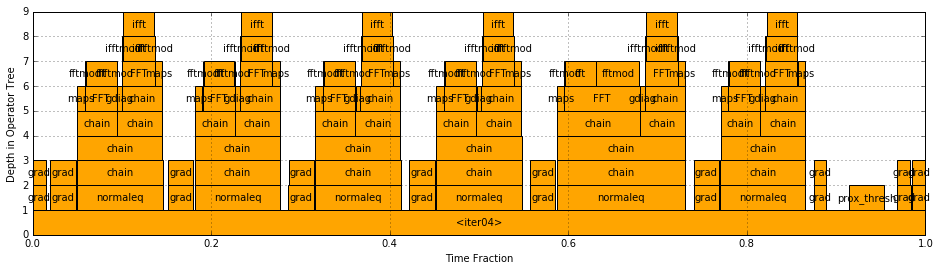

operation      time(%)
-----------  ---------
grad               23%
fft                21%
ifft               21%
unaccounted        13%
maps               10%
fftmod              5%
prox_thresh         4%
gdiag               3%
ifftmod             1%


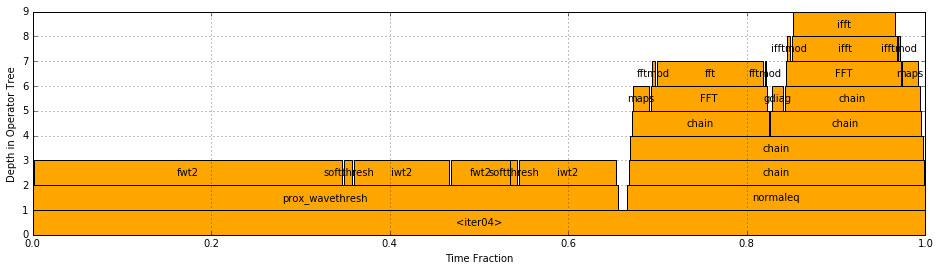

operation      time(%)
-----------  ---------
fwt2               41%
iwt2               22%
fft                12%
ifft               11%
unaccounted         7%
maps                4%
softthresh          2%
gdiag               1%
fftmod              1%
ifftmod             0%


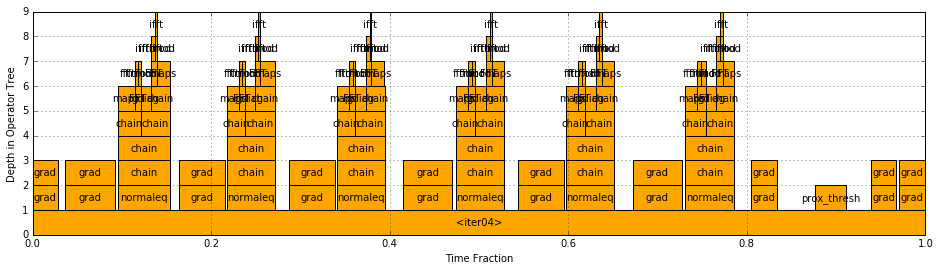

operation      time(%)
-----------  ---------
grad               44%
unaccounted        20%
maps               17%
gdiag               7%
prox_thresh         3%
ifftmod             2%
fftmod              2%
fft                 2%
ifft                2%


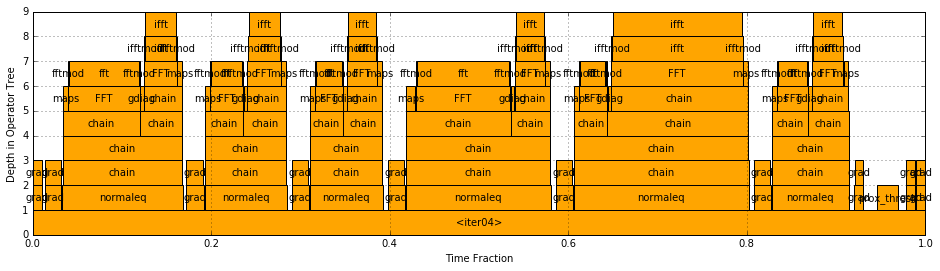

operation      time(%)
-----------  ---------
ifft               31%
fft                31%
grad               15%
unaccounted        11%
maps                6%
prox_thresh         2%
gdiag               2%
fftmod              1%
ifftmod             1%


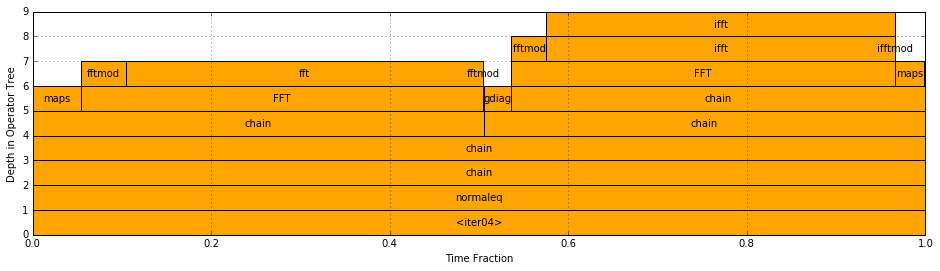

operation      time(%)
-----------  ---------
fft                40%
ifft               39%
maps                9%
fftmod              5%
ifftmod             4%
gdiag               3%
unaccounted         0%


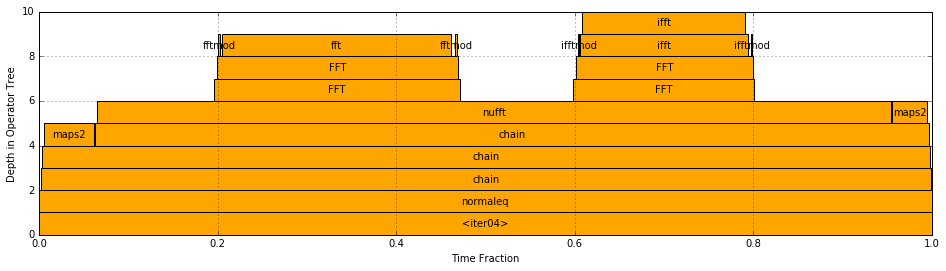

operation      time(%)
-----------  ---------
unaccounted        46%
fft                26%
ifft               18%
maps2               9%
fftmod              0%
ifftmod             0%


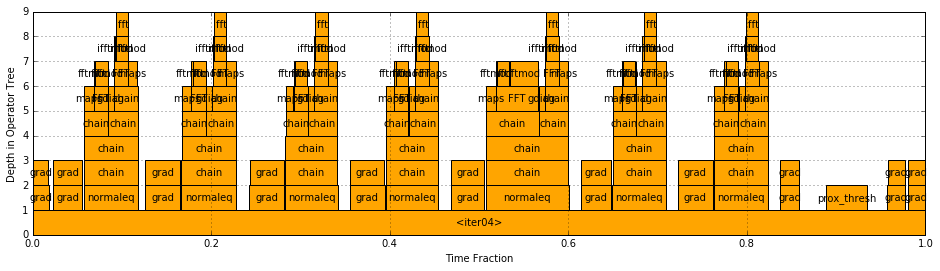

operation      time(%)
-----------  ---------
grad               33%
unaccounted        18%
maps               14%
fft                10%
ifft               10%
gdiag               5%
prox_thresh         5%
fftmod              4%
ifftmod             1%


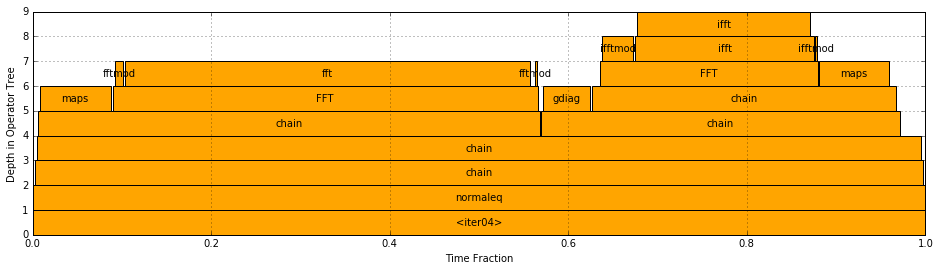

operation      time(%)
-----------  ---------
fft                45%
ifft               19%
maps               16%
unaccounted         9%
gdiag               5%
ifftmod             4%
fftmod              1%


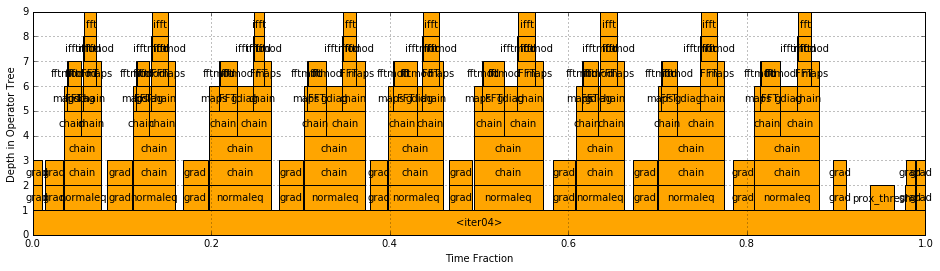

operation      time(%)
-----------  ---------
grad               27%
fft                17%
ifft               14%
unaccounted        14%
maps               12%
gdiag              11%
prox_thresh         3%
ifftmod             1%
fftmod              1%


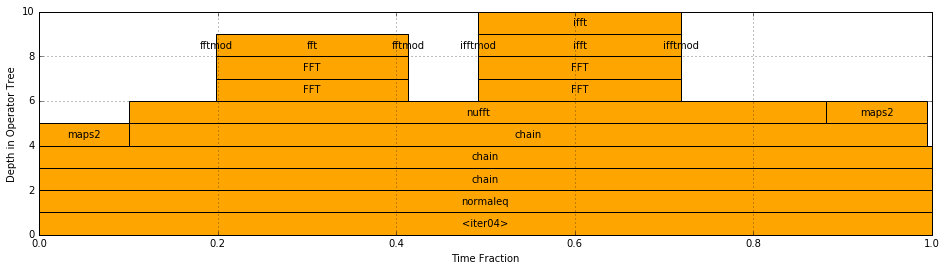

operation      time(%)
-----------  ---------
unaccounted        34%
ifft               23%
fft                22%
maps2              21%
fftmod              0%
ifftmod             0%


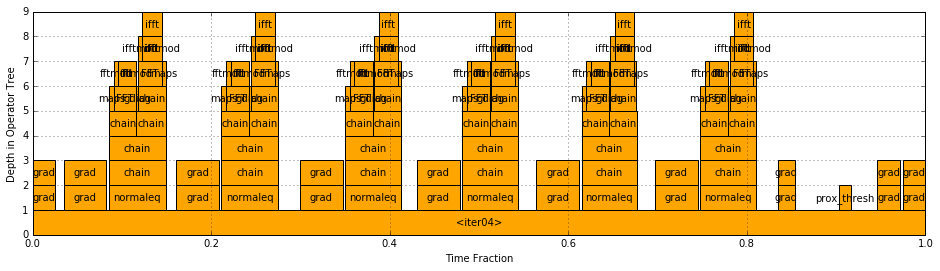

operation      time(%)
-----------  ---------
grad               38%
unaccounted        23%
ifft               13%
fft                12%
maps                5%
ifftmod             3%
fftmod              3%
prox_thresh         1%
gdiag               1%


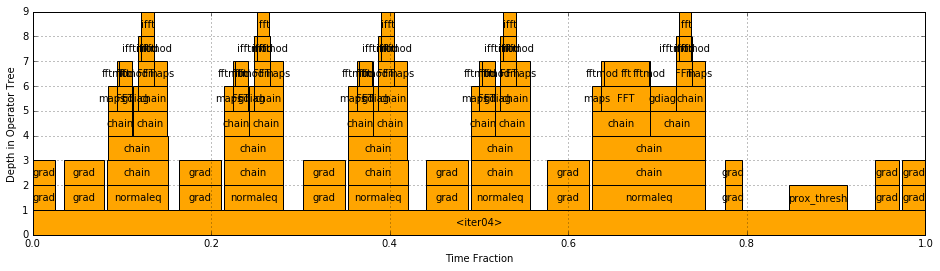

operation      time(%)
-----------  ---------
grad               33%
unaccounted        22%
maps               12%
fft                11%
ifft                7%
prox_thresh         7%
gdiag               5%
ifftmod             2%
fftmod              1%


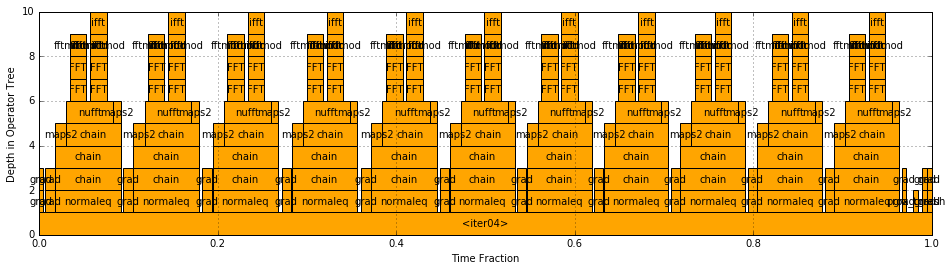

operation      time(%)
-----------  ---------
unaccounted        23%
maps2              23%
ifft               20%
fft                20%
grad               13%
prox_thresh         1%
fftmod              0%
ifftmod             0%


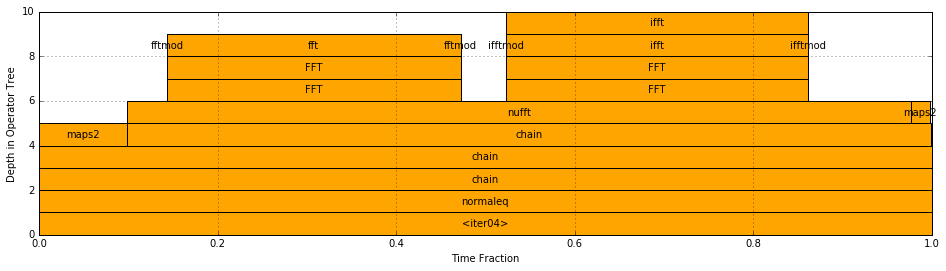

operation      time(%)
-----------  ---------
ifft               34%
fft                33%
unaccounted        21%
maps2              12%
ifftmod             0%
fftmod              0%


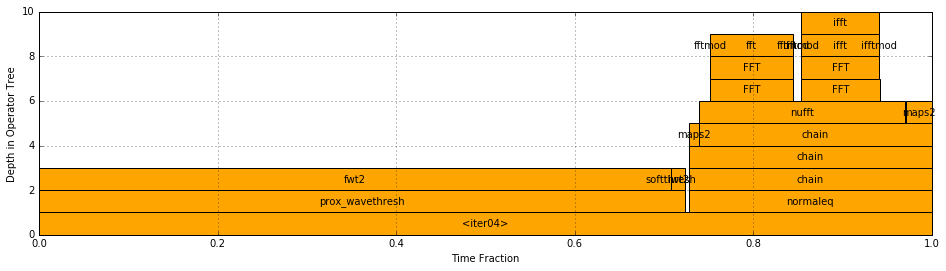

operation      time(%)
-----------  ---------
fwt2               71%
fft                 9%
ifft                9%
unaccounted         6%
maps2               4%
iwt2                2%
softthresh          0%
fftmod              0%
ifftmod             0%


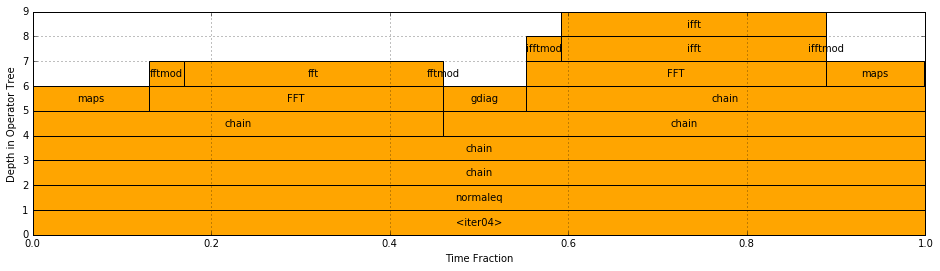

operation      time(%)
-----------  ---------
ifft               30%
fft                29%
maps               24%
gdiag               9%
fftmod              4%
ifftmod             4%
unaccounted         0%


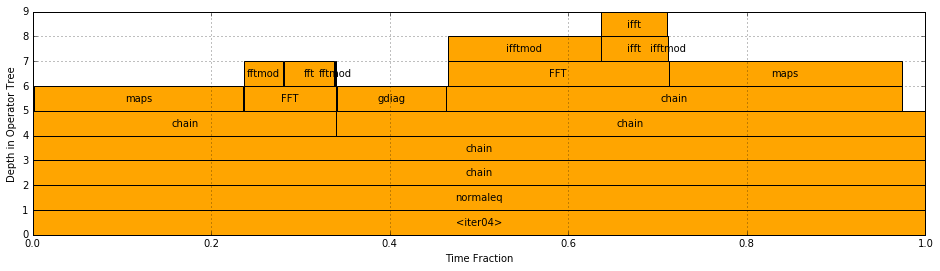

operation      time(%)
-----------  ---------
maps               50%
ifftmod            17%
gdiag              12%
ifft                7%
fft                 6%
fftmod              5%
unaccounted         4%


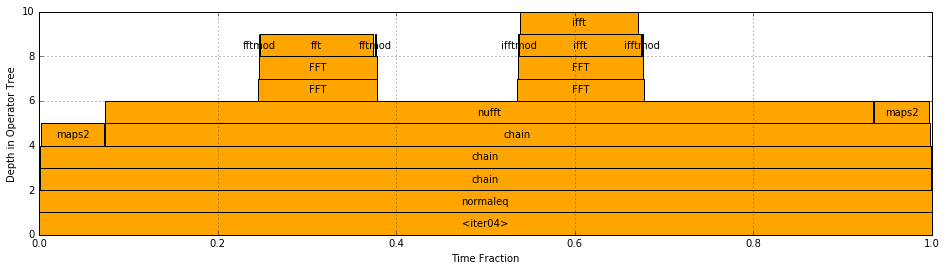

operation      time(%)
-----------  ---------
unaccounted        61%
maps2              13%
ifft               13%
fft                13%
fftmod              0%
ifftmod             0%


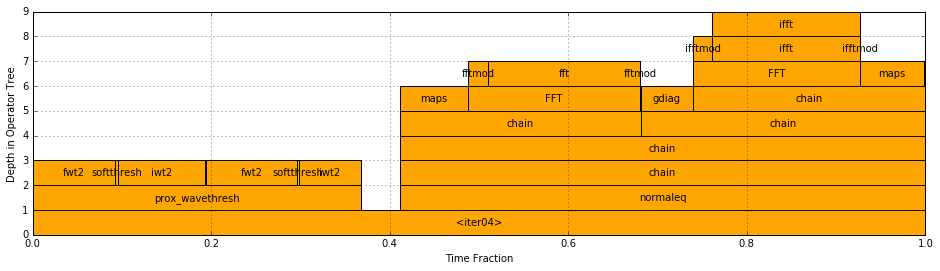

operation      time(%)
-----------  ---------
fwt2               20%
fft                17%
iwt2               17%
ifft               17%
maps               15%
gdiag               6%
unaccounted         5%
fftmod              2%
ifftmod             2%
softthresh          0%


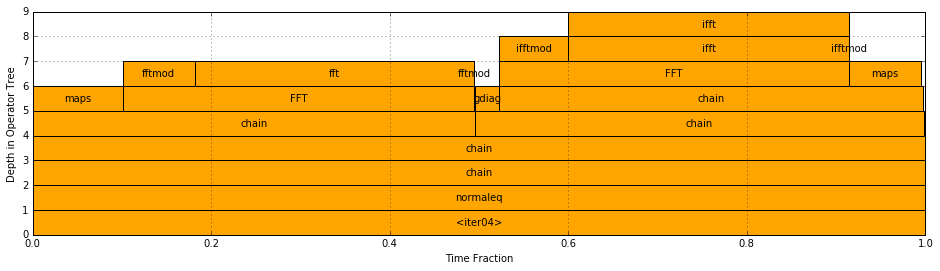

operation      time(%)
-----------  ---------
ifft               31%
fft                31%
maps               18%
fftmod              8%
ifftmod             8%
gdiag               3%
unaccounted         1%


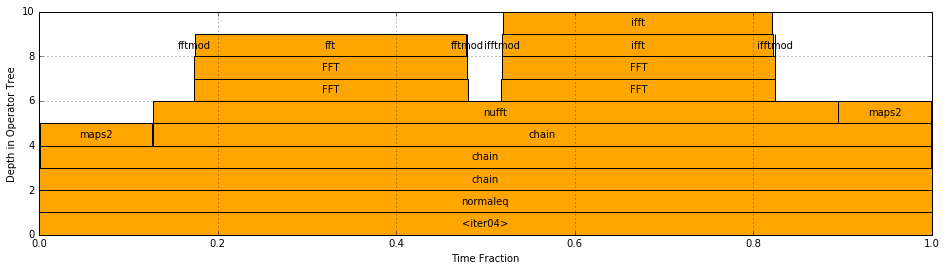

operation      time(%)
-----------  ---------
fft                30%
ifft               30%
maps2              23%
unaccounted        16%
fftmod              0%
ifftmod             0%


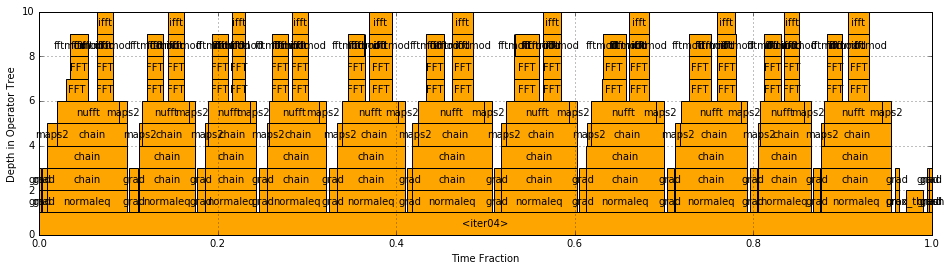

operation      time(%)
-----------  ---------
unaccounted        29%
fft                23%
ifft               22%
maps2              15%
grad               10%
prox_thresh         2%
fftmod              0%
ifftmod             0%


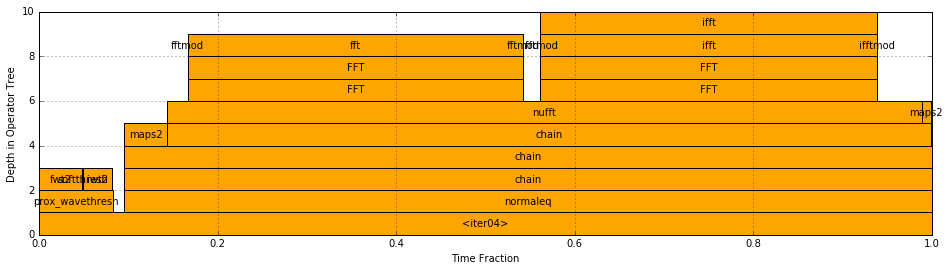

operation      time(%)
-----------  ---------
ifft               38%
fft                38%
unaccounted        11%
maps2               6%
fwt2                5%
iwt2                3%
softthresh          0%
fftmod              0%
ifftmod             0%


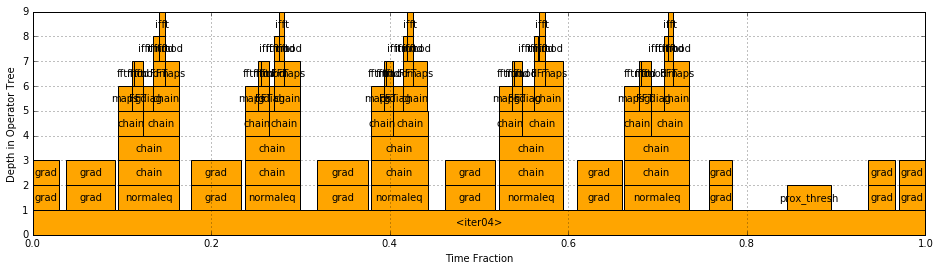

operation      time(%)
-----------  ---------
grad               39%
unaccounted        23%
maps               16%
gdiag               6%
prox_thresh         5%
fft                 5%
ifft                3%
ifftmod             3%
fftmod              1%


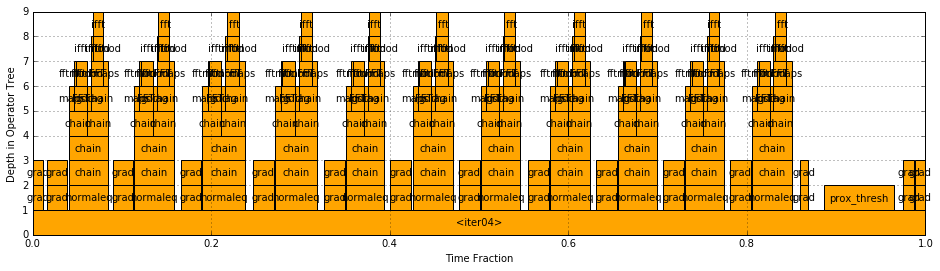

operation      time(%)
-----------  ---------
grad               30%
fft                14%
ifft               14%
unaccounted        13%
maps               13%
prox_thresh         8%
gdiag               5%
ifftmod             2%
fftmod              2%


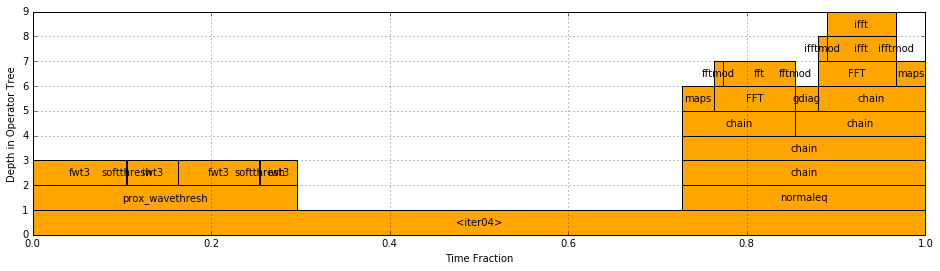

operation      time(%)
-----------  ---------
unaccounted        43%
fwt3               20%
iwt3               10%
fft                 8%
ifft                8%
maps                7%
gdiag               3%
ifftmod             1%
fftmod              1%
softthresh          0%


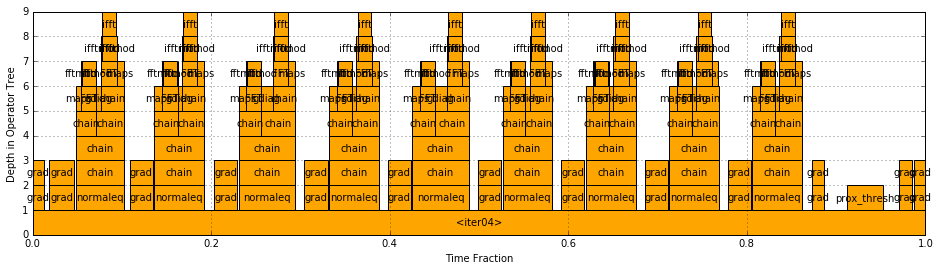

operation      time(%)
-----------  ---------
grad               29%
unaccounted        16%
maps               14%
fft                14%
ifft               14%
gdiag               6%
prox_thresh         4%
ifftmod             1%
fftmod              1%


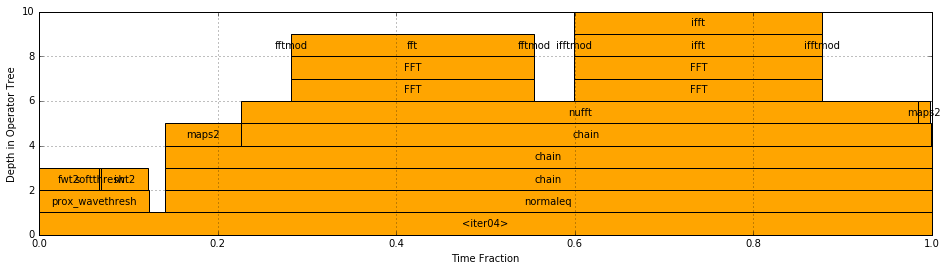

operation      time(%)
-----------  ---------
ifft               28%
fft                27%
unaccounted        23%
maps2              10%
fwt2                7%
iwt2                5%
softthresh          0%
fftmod              0%
ifftmod             0%


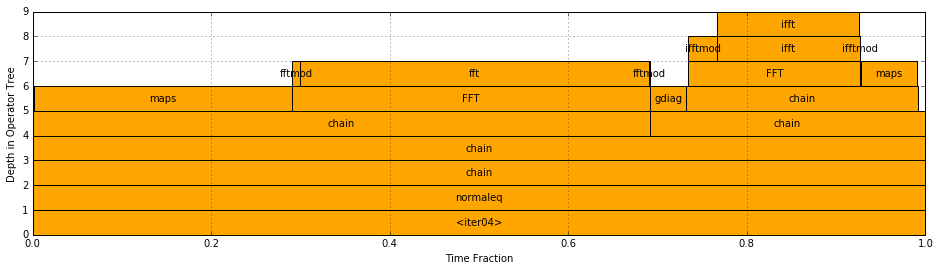

operation      time(%)
-----------  ---------
fft                39%
maps               35%
ifft               16%
gdiag               4%
ifftmod             3%
unaccounted         2%
fftmod              1%


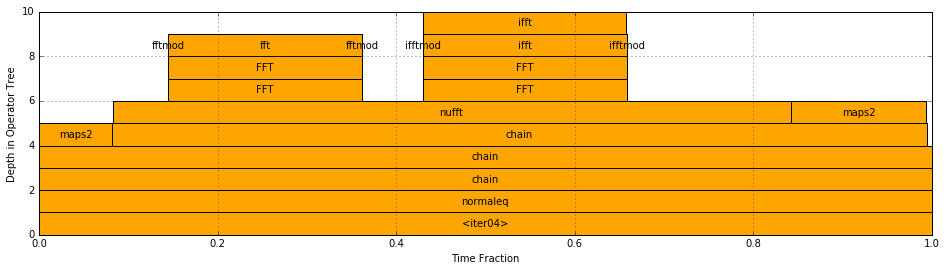

operation      time(%)
-----------  ---------
unaccounted        32%
maps2              23%
ifft               23%
fft                22%
fftmod              0%
ifftmod             0%


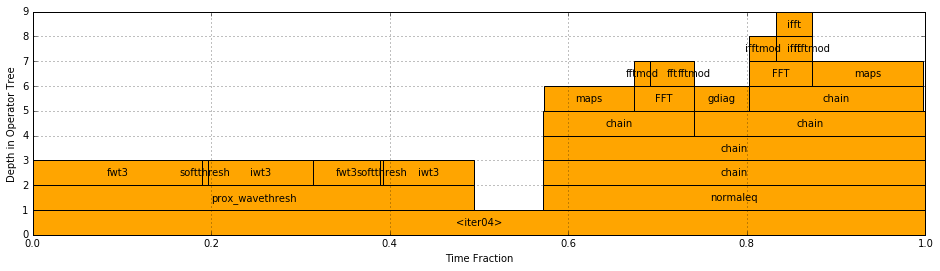

operation      time(%)
-----------  ---------
fwt3               26%
maps               23%
iwt3               22%
unaccounted         8%
gdiag               6%
fft                 5%
ifft                4%
ifftmod             3%
fftmod              2%
softthresh          1%


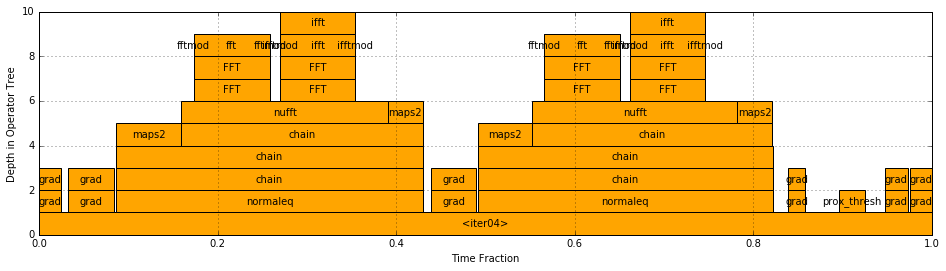

operation      time(%)
-----------  ---------
unaccounted        22%
maps2              21%
grad               20%
fft                17%
ifft               17%
prox_thresh         3%
fftmod              0%
ifftmod             0%


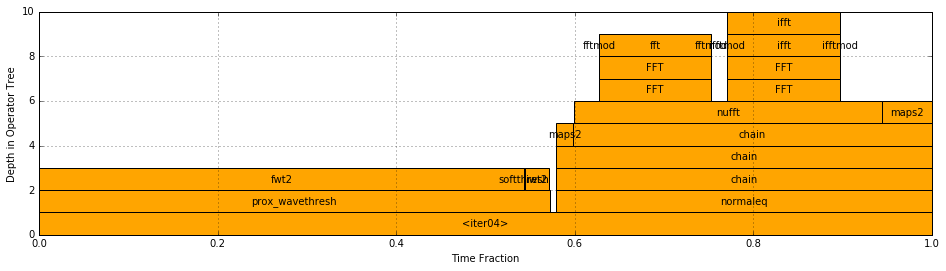

operation      time(%)
-----------  ---------
fwt2               54%
ifft               13%
fft                13%
unaccounted        10%
maps2               7%
iwt2                3%
softthresh          0%
ifftmod             0%
fftmod              0%


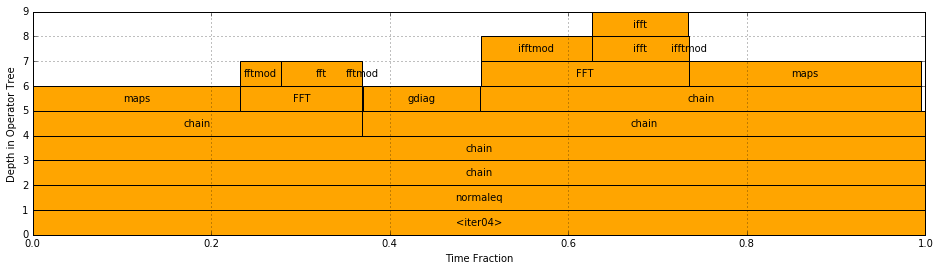

operation      time(%)
-----------  ---------
maps               49%
gdiag              13%
ifftmod            12%
ifft               11%
fft                 9%
fftmod              5%
unaccounted         1%


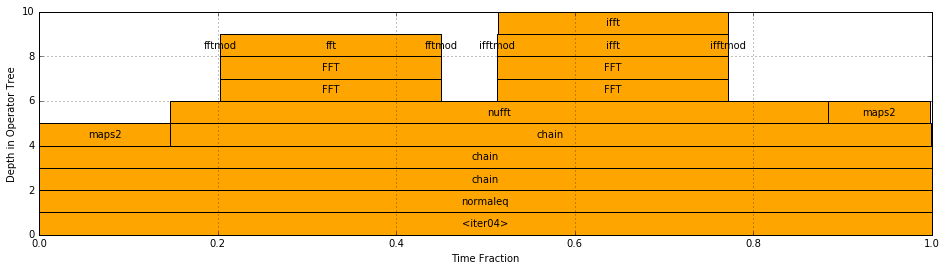

operation      time(%)
-----------  ---------
maps2              26%
ifft               26%
fft                25%
unaccounted        23%
fftmod              0%
ifftmod             0%


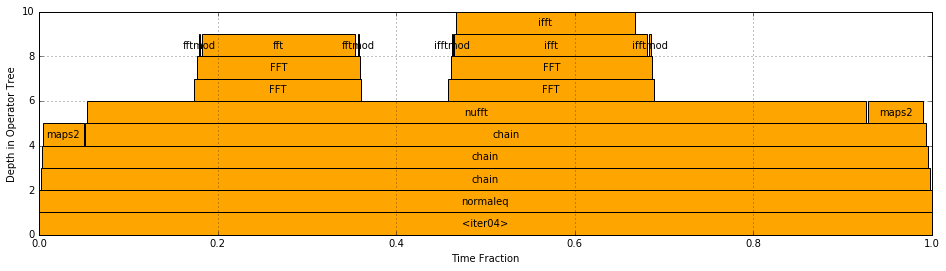

operation      time(%)
-----------  ---------
unaccounted        51%
ifft               20%
fft                17%
maps2              11%
ifftmod             0%
fftmod              0%


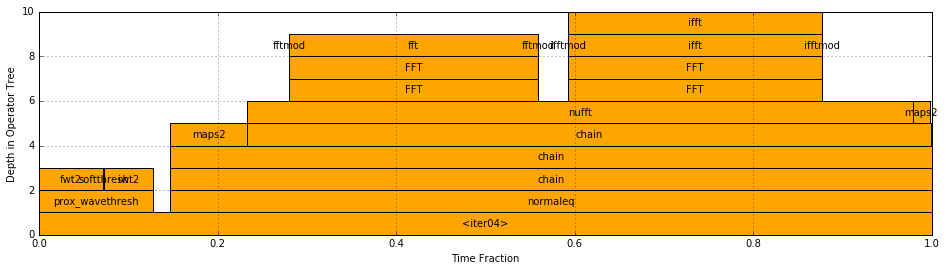

operation      time(%)
-----------  ---------
ifft               28%
fft                28%
unaccounted        20%
maps2              11%
fwt2                7%
iwt2                5%
softthresh          0%
ifftmod             0%
fftmod              0%


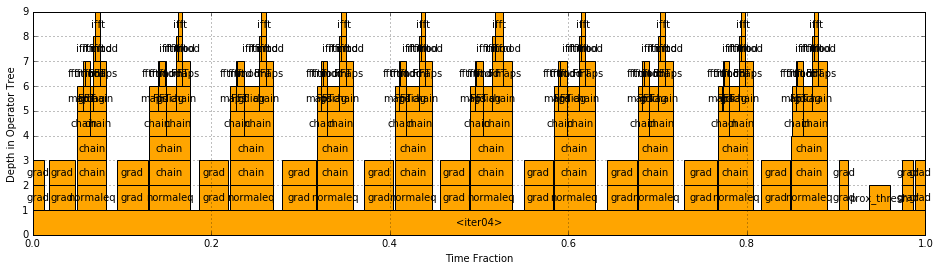

operation      time(%)
-----------  ---------
grad               38%
unaccounted        18%
maps               14%
gdiag              11%
fft                 7%
ifft                5%
ifftmod             2%
prox_thresh         2%
fftmod              1%


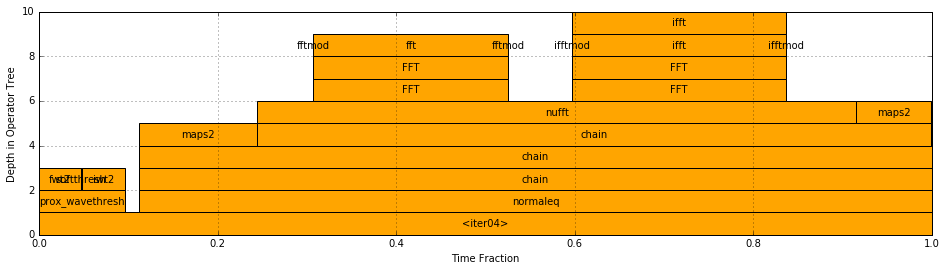

operation      time(%)
-----------  ---------
ifft               24%
unaccounted        23%
fft                22%
maps2              22%
iwt2                5%
fwt2                5%
softthresh          0%
fftmod              0%
ifftmod             0%


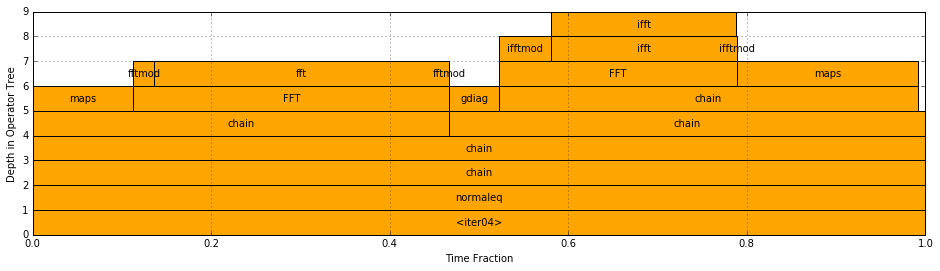

operation      time(%)
-----------  ---------
fft                33%
maps               31%
ifft               21%
ifftmod             6%
gdiag               6%
fftmod              2%
unaccounted         1%


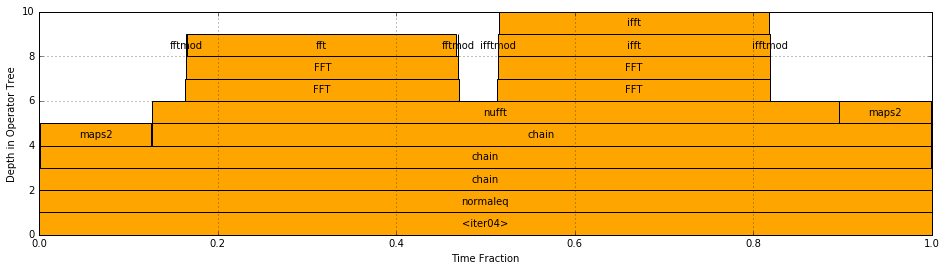

operation      time(%)
-----------  ---------
ifft               30%
fft                30%
maps2              23%
unaccounted        17%
fftmod              0%
ifftmod             0%


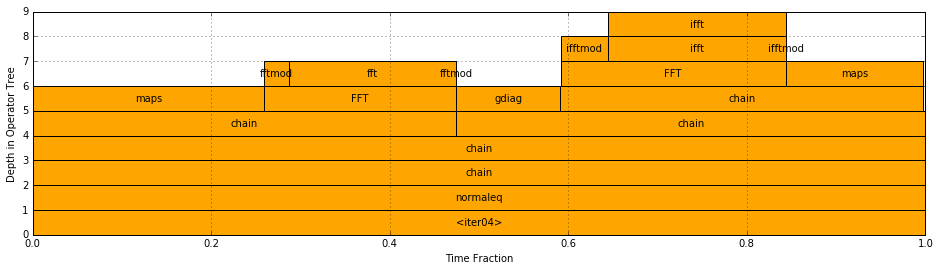

operation      time(%)
-----------  ---------
maps               41%
ifft               20%
fft                19%
gdiag              12%
ifftmod             5%
fftmod              3%
unaccounted         0%


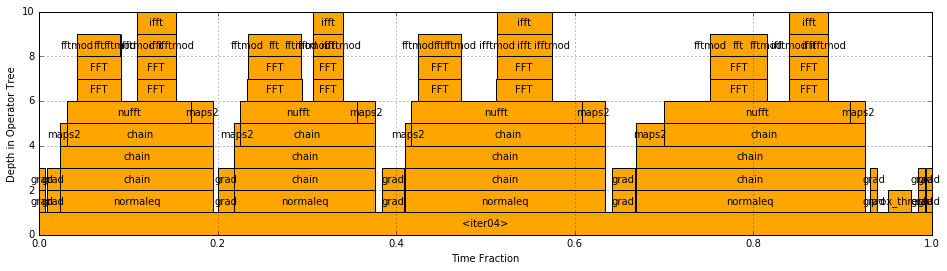

operation      time(%)
-----------  ---------
unaccounted        32%
fft                22%
ifft               18%
maps2              14%
grad               11%
prox_thresh         3%
fftmod              0%
ifftmod             0%


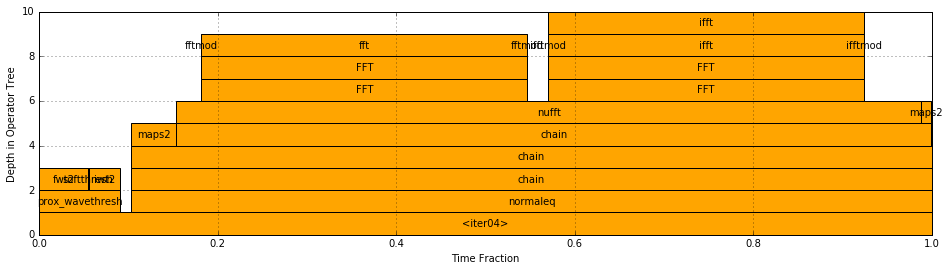

operation      time(%)
-----------  ---------
fft                37%
ifft               35%
unaccounted        13%
maps2               6%
fwt2                5%
iwt2                4%
softthresh          0%
fftmod              0%
ifftmod             0%


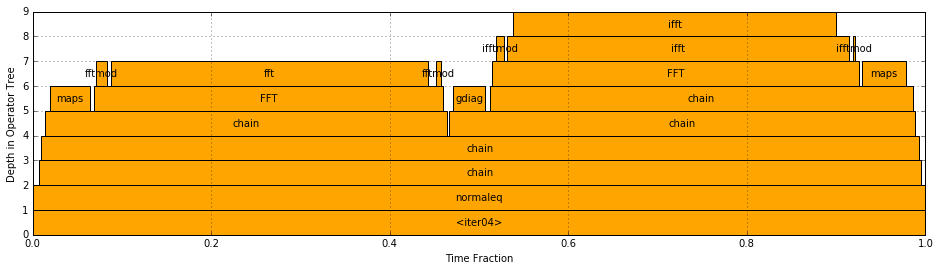

operation      time(%)
-----------  ---------
ifft               36%
fft                35%
unaccounted        12%
maps               10%
gdiag               4%
fftmod              2%
ifftmod             1%


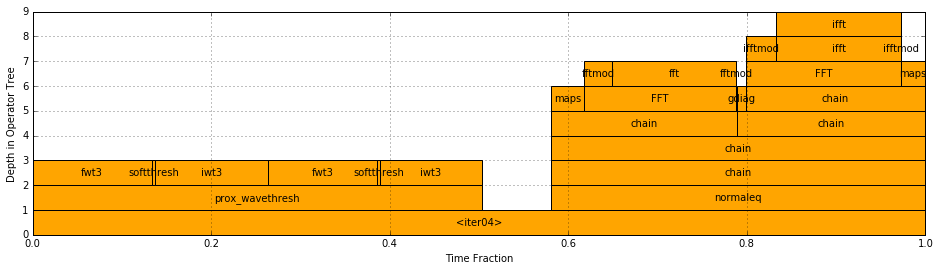

operation      time(%)
-----------  ---------
fwt3               26%
iwt3               24%
ifft               14%
fft                14%
unaccounted         8%
maps                6%
ifftmod             3%
fftmod              3%
gdiag               1%
softthresh          1%


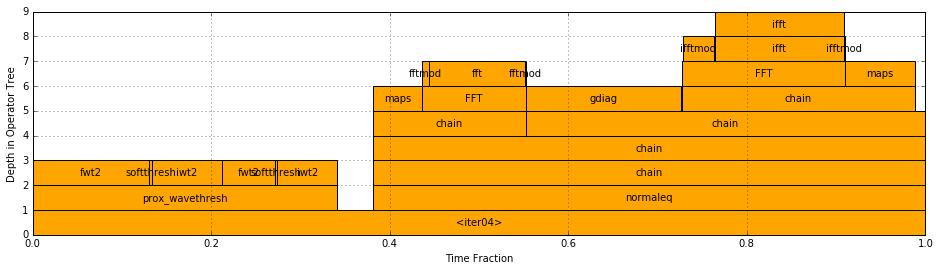

operation      time(%)
-----------  ---------
fwt2               19%
gdiag              17%
iwt2               15%
ifft               15%
maps               13%
fft                11%
unaccounted         6%
ifftmod             4%
fftmod              1%
softthresh          1%


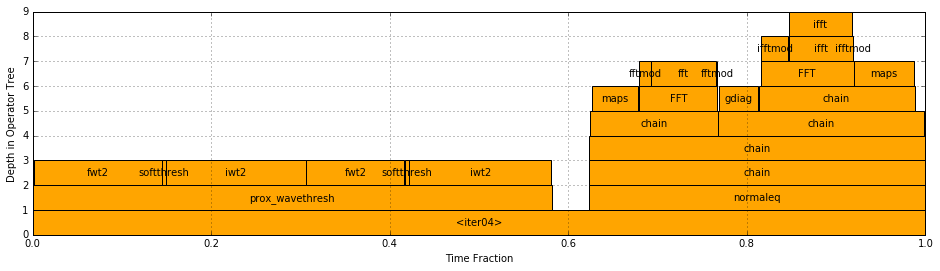

operation      time(%)
-----------  ---------
iwt2               32%
fwt2               25%
maps               12%
unaccounted         7%
fft                 7%
ifft                7%
gdiag               4%
ifftmod             3%
fftmod              1%
softthresh          1%


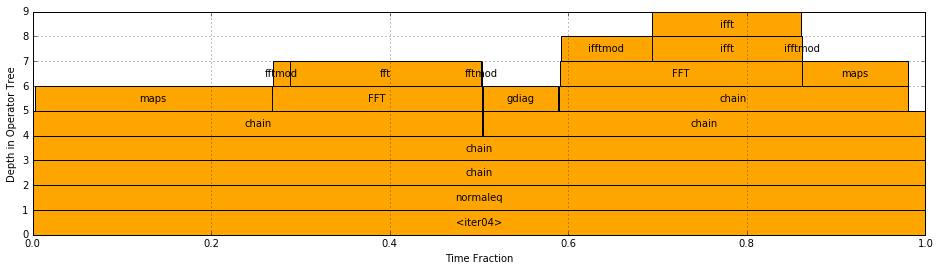

operation      time(%)
-----------  ---------
maps               38%
fft                21%
ifft               17%
ifftmod            10%
gdiag               8%
unaccounted         3%
fftmod              2%


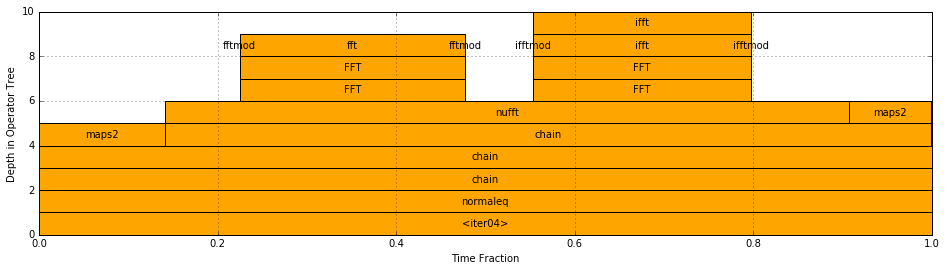

operation      time(%)
-----------  ---------
unaccounted        27%
fft                25%
ifft               24%
maps2              23%
fftmod              0%
ifftmod             0%


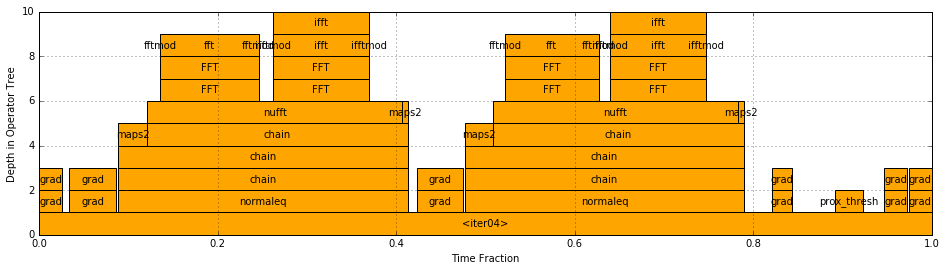

operation      time(%)
-----------  ---------
unaccounted        26%
ifft               22%
fft                22%
grad               20%
maps2               8%
prox_thresh         3%
fftmod              0%
ifftmod             0%


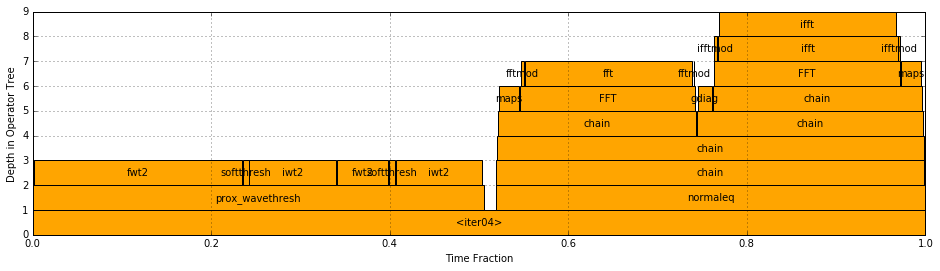

operation      time(%)
-----------  ---------
fwt2               29%
ifft               20%
iwt2               19%
fft                19%
unaccounted         5%
maps                4%
gdiag               2%
softthresh          1%
fftmod              0%
ifftmod             0%


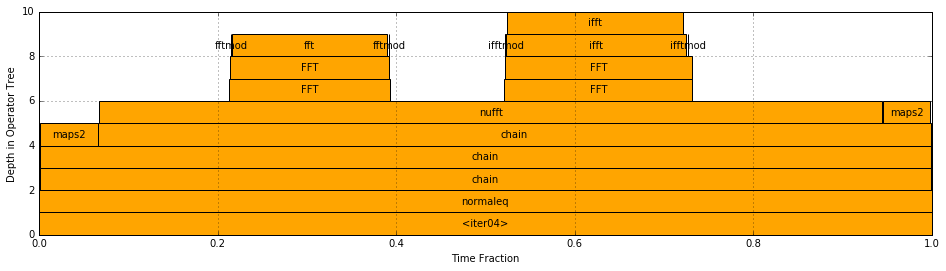

operation      time(%)
-----------  ---------
unaccounted        51%
ifft               20%
fft                17%
maps2              12%
ifftmod             0%
fftmod              0%


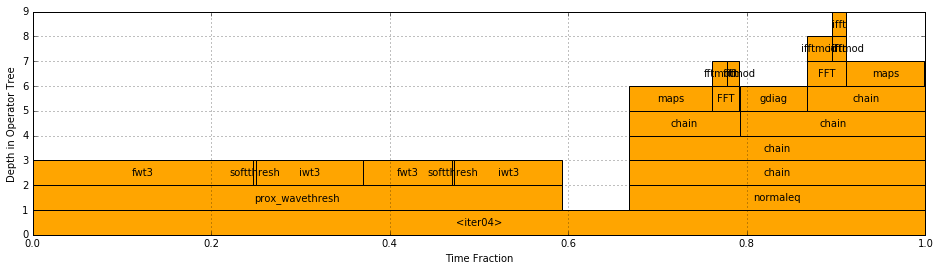

operation      time(%)
-----------  ---------
fwt3               35%
iwt3               24%
maps               18%
unaccounted         8%
gdiag               7%
ifftmod             3%
fftmod              2%
ifft                2%
fft                 1%
softthresh          1%


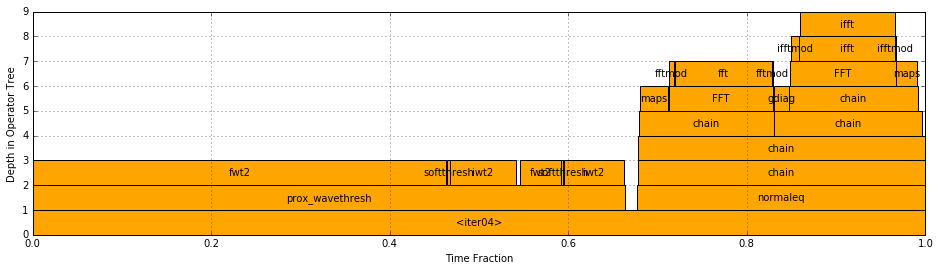

operation      time(%)
-----------  ---------
fwt2               51%
iwt2               14%
fft                11%
ifft               11%
maps                6%
unaccounted         4%
gdiag               2%
ifftmod             1%
fftmod              1%
softthresh          0%


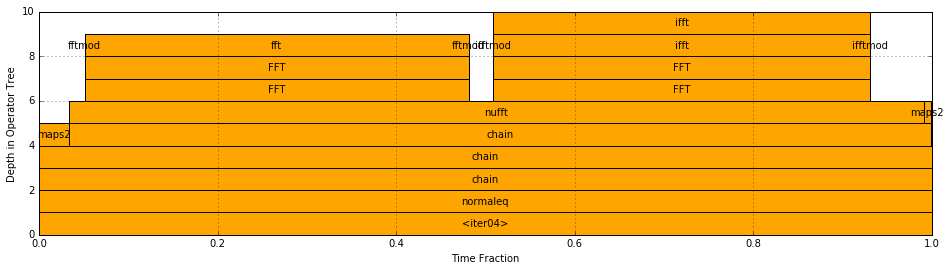

operation      time(%)
-----------  ---------
fft                43%
ifft               42%
unaccounted        11%
maps2               4%
fftmod              0%
ifftmod             0%


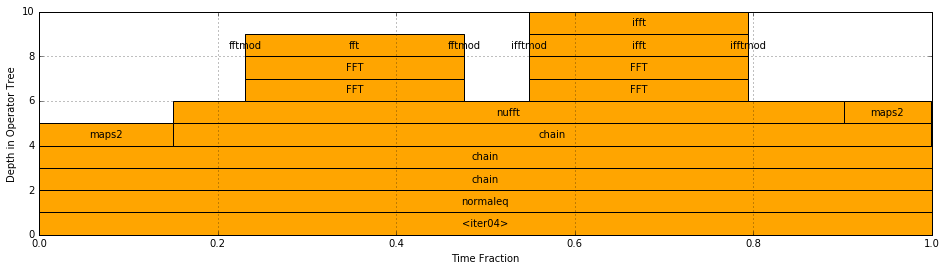

operation      time(%)
-----------  ---------
unaccounted        26%
maps2              25%
fft                25%
ifft               24%
fftmod              0%
ifftmod             0%


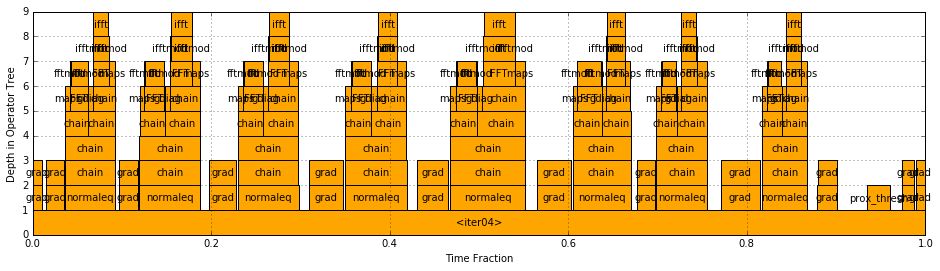

operation      time(%)
-----------  ---------
grad               30%
ifft               17%
fft                16%
unaccounted        16%
maps               12%
gdiag               4%
prox_thresh         3%
fftmod              1%
ifftmod             1%


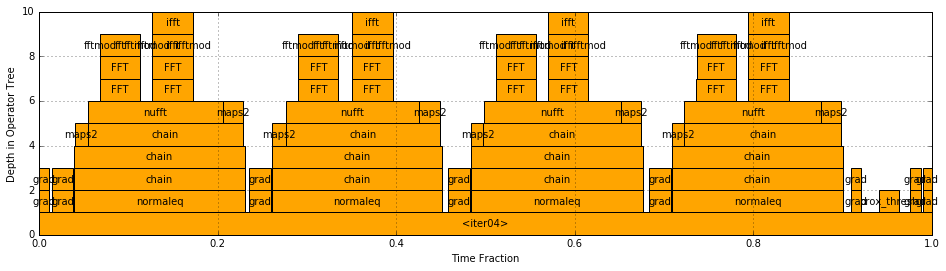

operation      time(%)
-----------  ---------
unaccounted        33%
ifft               18%
fft                18%
maps2              15%
grad               15%
prox_thresh         2%
fftmod              0%
ifftmod             0%


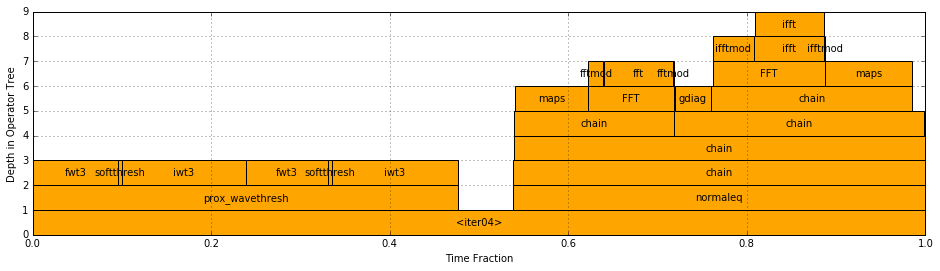

operation      time(%)
-----------  ---------
iwt3               28%
fwt3               19%
maps               18%
unaccounted         9%
ifft                8%
fft                 8%
ifftmod             5%
gdiag               4%
fftmod              2%
softthresh          1%


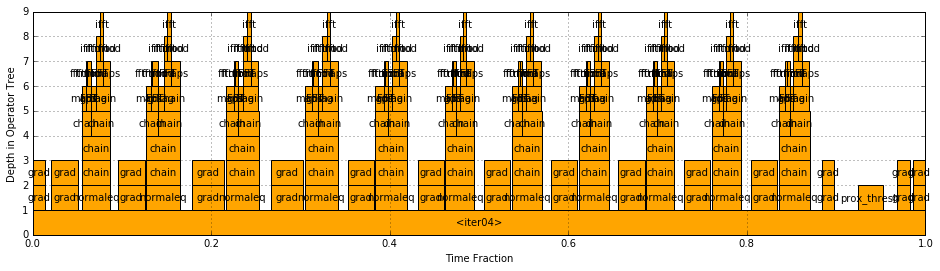

operation      time(%)
-----------  ---------
grad               39%
unaccounted        20%
maps               18%
ifftmod             5%
gdiag               5%
fft                 4%
ifft                4%
prox_thresh         3%
fftmod              1%


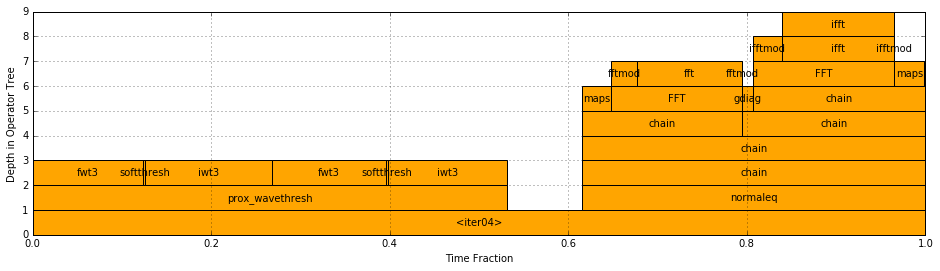

operation      time(%)
-----------  ---------
iwt3               28%
fwt3               25%
ifft               13%
fft                12%
unaccounted         9%
maps                7%
ifftmod             3%
fftmod              3%
gdiag               1%
softthresh          0%


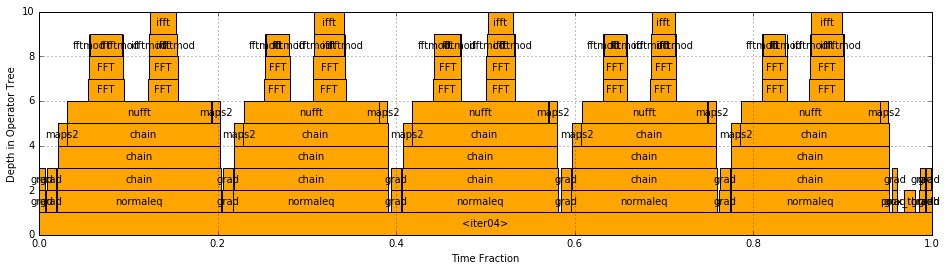

operation      time(%)
-----------  ---------
unaccounted        52%
ifft               15%
fft                14%
maps2               9%
grad                8%
prox_thresh         1%
fftmod              0%
ifftmod             0%


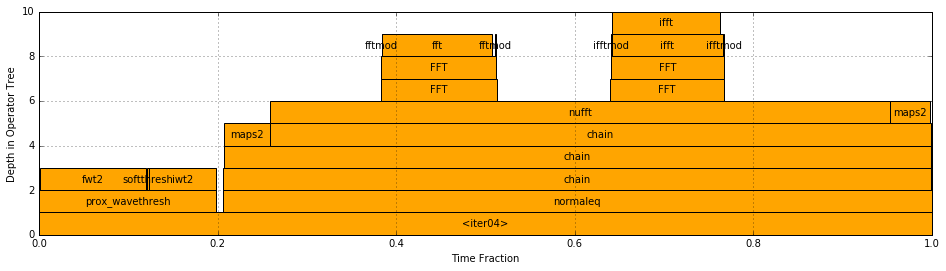

operation      time(%)
-----------  ---------
unaccounted        46%
fft                12%
ifft               12%
fwt2               12%
maps2              10%
iwt2                7%
softthresh          0%
fftmod              0%
ifftmod             0%


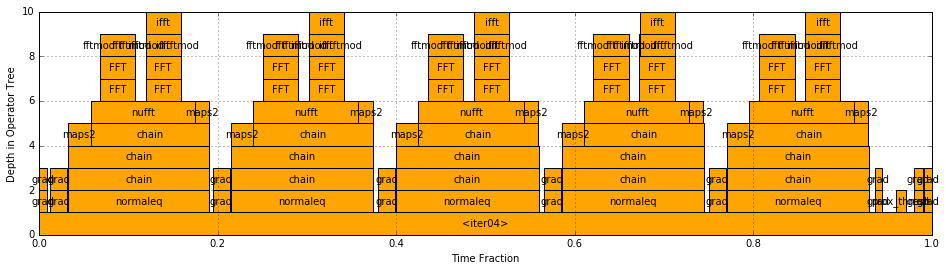

operation      time(%)
-----------  ---------
unaccounted        25%
maps2              20%
fft                20%
ifft               20%
grad               13%
prox_thresh         1%
fftmod              0%
ifftmod             0%


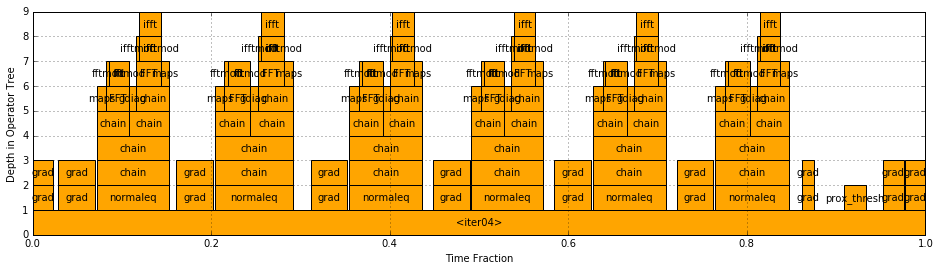

operation      time(%)
-----------  ---------
grad               33%
unaccounted        15%
ifft               14%
fft                14%
maps               12%
gdiag               5%
prox_thresh         2%
fftmod              2%
ifftmod             2%


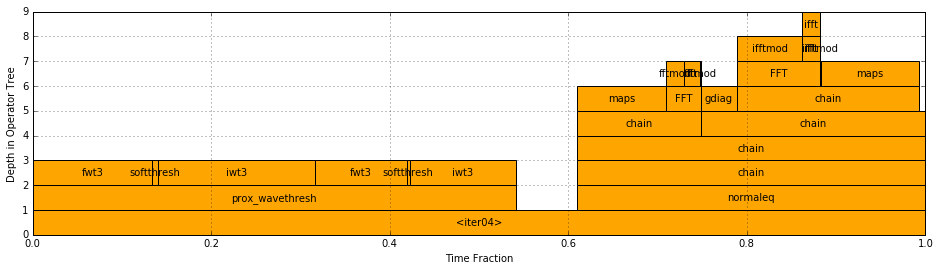

operation      time(%)
-----------  ---------
iwt3               29%
fwt3               24%
maps               21%
unaccounted         8%
ifftmod             7%
gdiag               4%
fftmod              2%
ifft                2%
fft                 2%
softthresh          1%


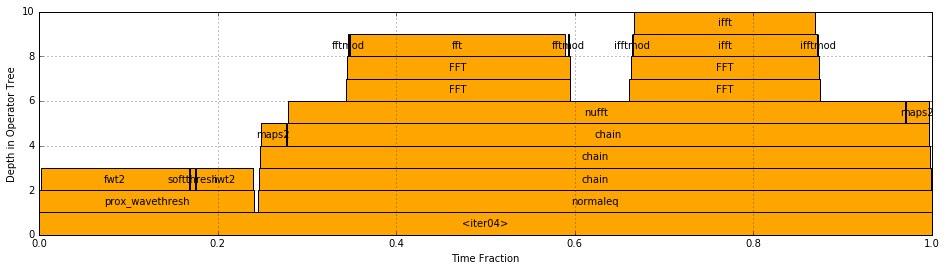

operation      time(%)
-----------  ---------
unaccounted        26%
fft                24%
ifft               20%
fwt2               17%
iwt2                6%
maps2               5%
softthresh          1%
fftmod              0%
ifftmod             0%


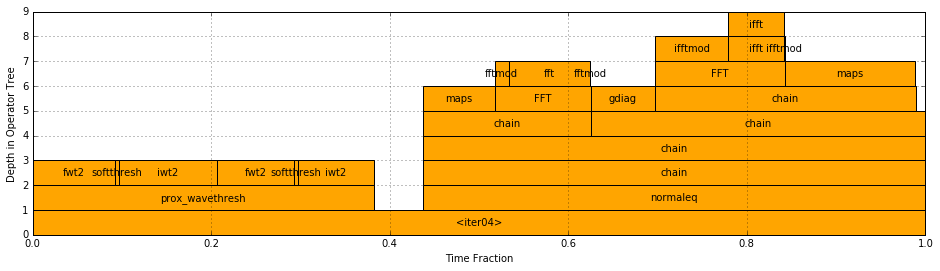

operation      time(%)
-----------  ---------
maps               23%
iwt2               19%
fwt2               18%
fft                 9%
ifftmod             8%
gdiag               7%
unaccounted         7%
ifft                6%
fftmod              2%
softthresh          1%


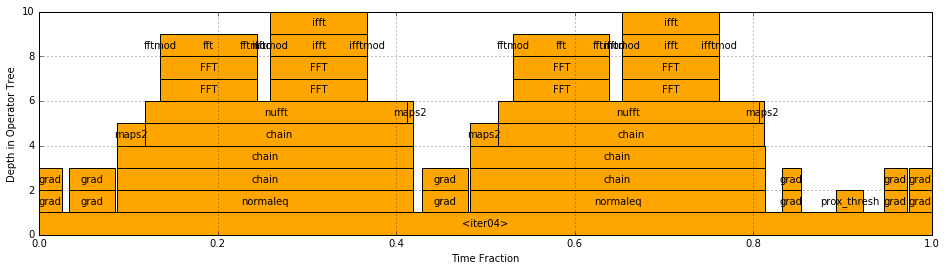

operation      time(%)
-----------  ---------
unaccounted        26%
ifft               22%
fft                22%
grad               20%
maps2               7%
prox_thresh         3%
fftmod              0%
ifftmod             0%


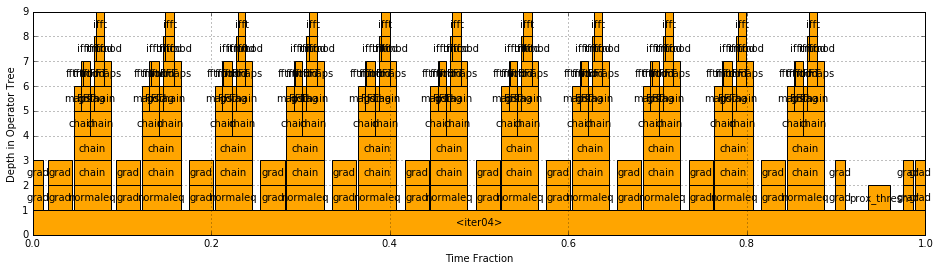

operation      time(%)
-----------  ---------
grad               34%
maps               18%
unaccounted        17%
ifft               10%
fft                 9%
gdiag               5%
ifftmod             3%
prox_thresh         2%
fftmod              1%


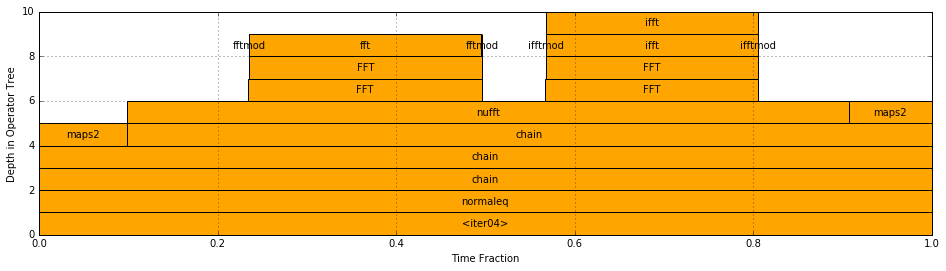

operation      time(%)
-----------  ---------
unaccounted        31%
fft                26%
ifft               24%
maps2              19%
fftmod              0%
ifftmod             0%


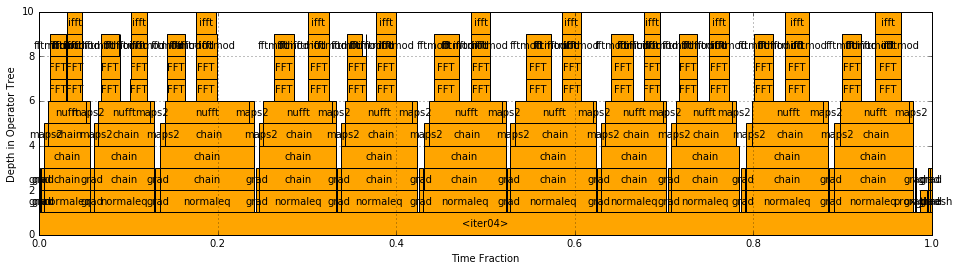

operation      time(%)
-----------  ---------
unaccounted        35%
fft                24%
ifft               24%
maps2              11%
grad                5%
prox_thresh         1%
fftmod              0%
ifftmod             0%


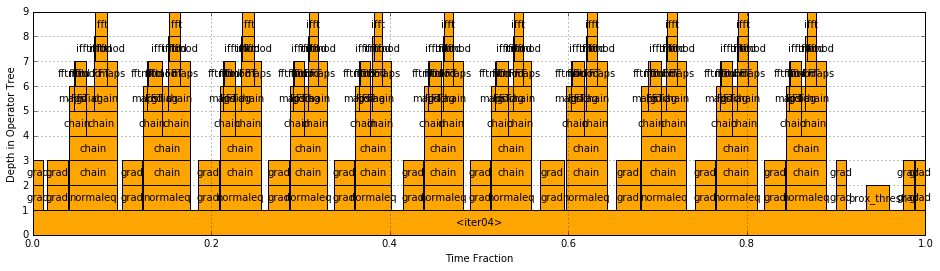

operation      time(%)
-----------  ---------
grad               31%
maps               17%
unaccounted        16%
fft                14%
ifft               12%
gdiag               6%
prox_thresh         3%
ifftmod             1%
fftmod              1%


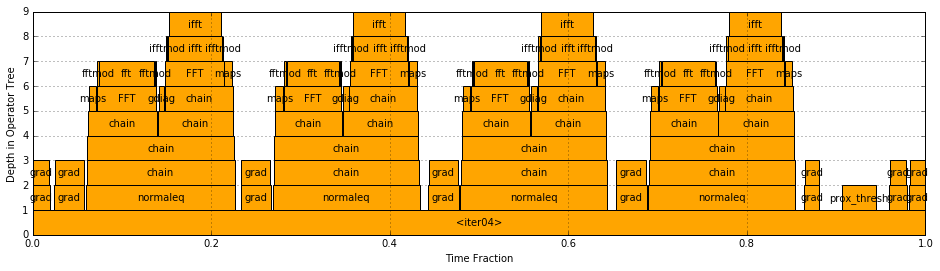

operation      time(%)
-----------  ---------
fft                24%
ifft               23%
grad               20%
unaccounted        18%
maps                7%
prox_thresh         4%
gdiag               3%
ifftmod             1%
fftmod              1%


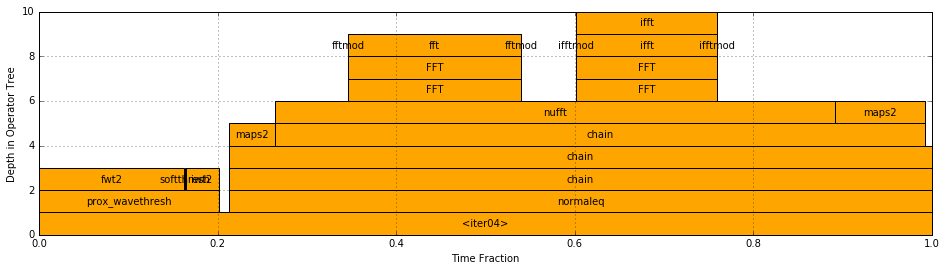

operation      time(%)
-----------  ---------
unaccounted        30%
fft                19%
fwt2               16%
ifft               16%
maps2              15%
iwt2                4%
softthresh          0%
fftmod              0%
ifftmod             0%


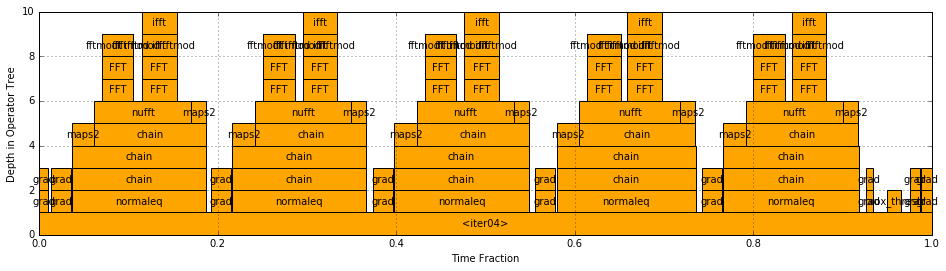

operation      time(%)
-----------  ---------
unaccounted        25%
maps2              21%
ifft               19%
fft                18%
grad               15%
prox_thresh         2%
fftmod              0%
ifftmod             0%


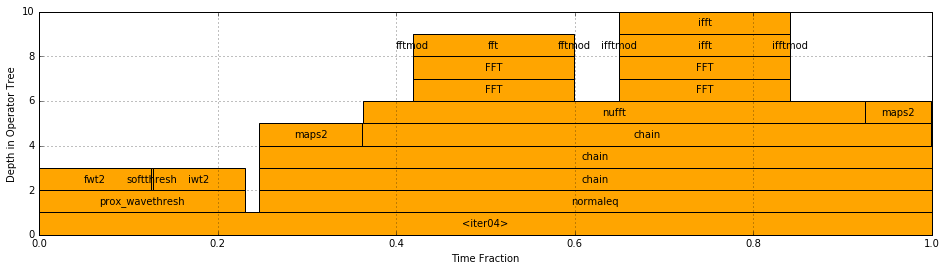

operation      time(%)
-----------  ---------
unaccounted        21%
ifft               19%
maps2              19%
fft                18%
fwt2               13%
iwt2               10%
softthresh          0%
fftmod              0%
ifftmod             0%


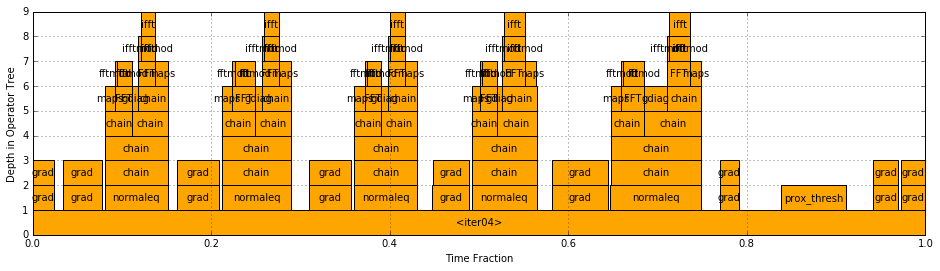

operation      time(%)
-----------  ---------
grad               34%
unaccounted        20%
maps               12%
ifft               10%
fft                 9%
prox_thresh         7%
gdiag               5%
fftmod              1%
ifftmod             1%


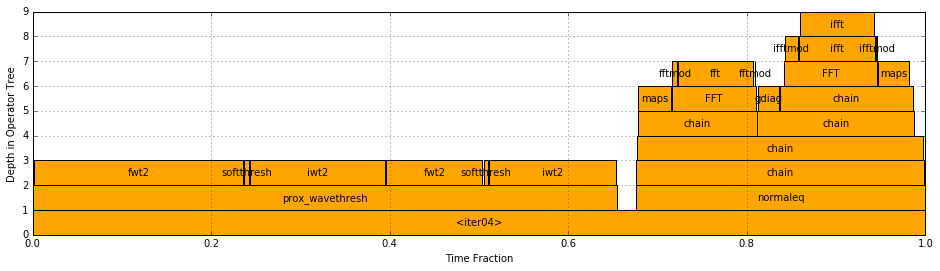

operation      time(%)
-----------  ---------
fwt2               34%
iwt2               29%
fft                 8%
ifft                8%
maps                7%
unaccounted         7%
gdiag               2%
ifftmod             2%
softthresh          1%
fftmod              1%


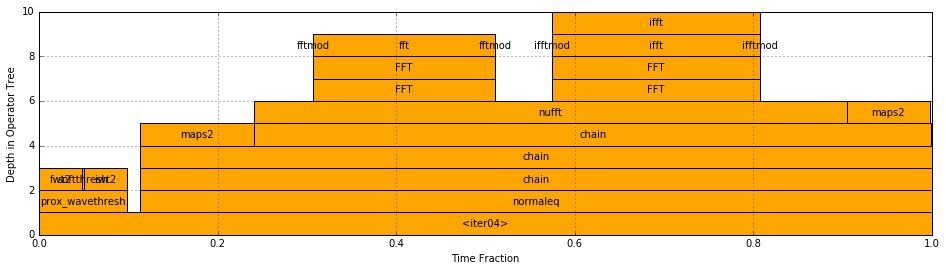

operation      time(%)
-----------  ---------
unaccounted        25%
ifft               23%
maps2              22%
fft                20%
fwt2                5%
iwt2                5%
softthresh          0%
fftmod              0%
ifftmod             0%


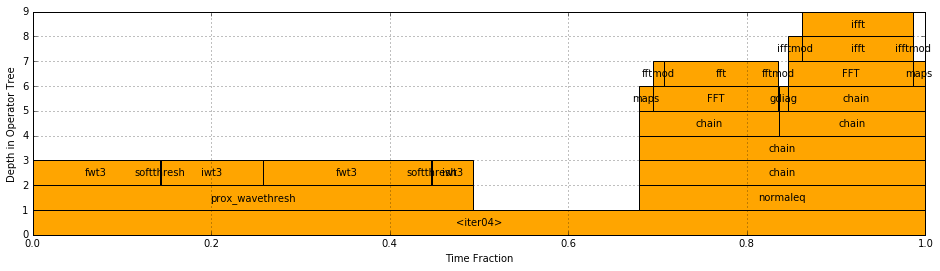

operation      time(%)
-----------  ---------
fwt3               33%
unaccounted        19%
iwt3               16%
fft                13%
ifft               12%
maps                3%
ifftmod             2%
fftmod              1%
gdiag               1%
softthresh          0%


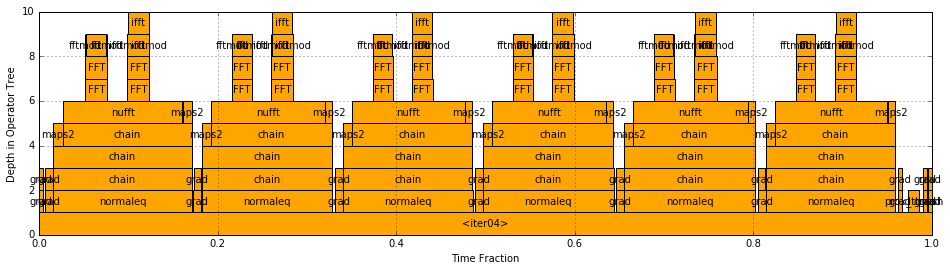

operation      time(%)
-----------  ---------
unaccounted        54%
ifft               14%
fft                13%
maps2              11%
grad                7%
prox_thresh         1%
fftmod              0%
ifftmod             0%


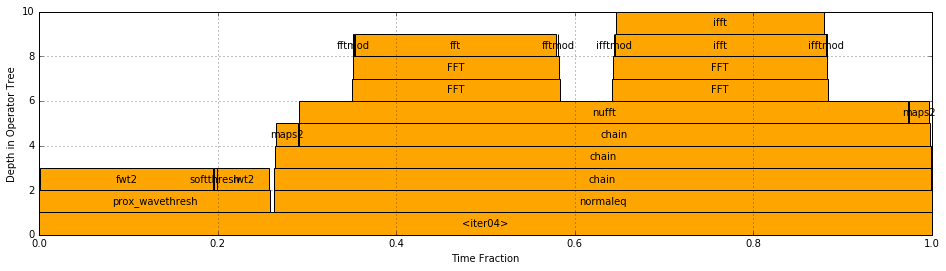

operation      time(%)
-----------  ---------
unaccounted        24%
ifft               23%
fft                23%
fwt2               19%
iwt2                6%
maps2               5%
softthresh          0%
fftmod              0%
ifftmod             0%


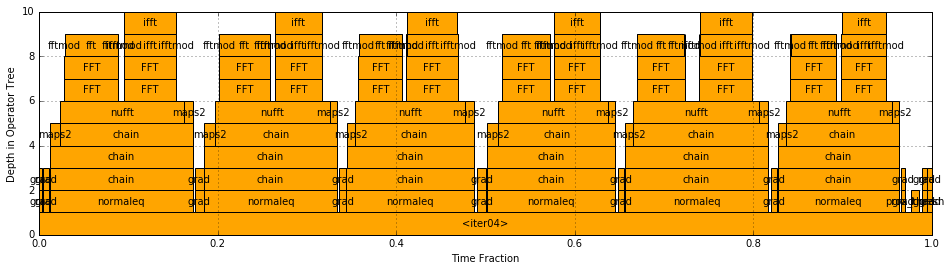

operation      time(%)
-----------  ---------
ifft               33%
fft                32%
unaccounted        16%
maps2              12%
grad                7%
prox_thresh         1%
fftmod              0%
ifftmod             0%


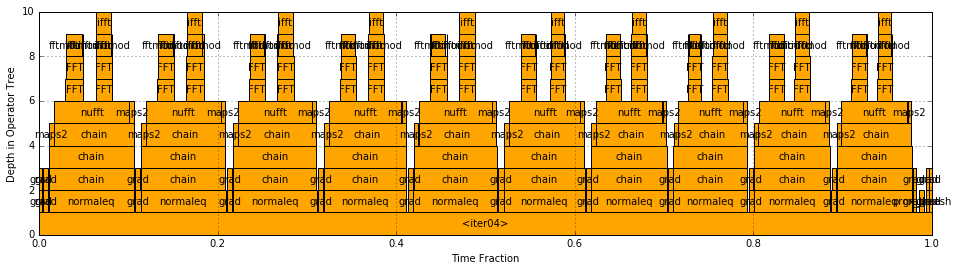

operation      time(%)
-----------  ---------
unaccounted        51%
ifft               16%
fft                16%
maps2               9%
grad                7%
prox_thresh         1%
ifftmod             0%
fftmod              0%


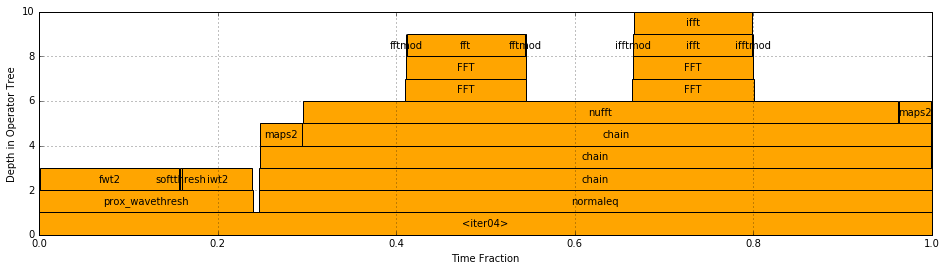

operation      time(%)
-----------  ---------
unaccounted        41%
fwt2               16%
ifft               13%
fft                13%
maps2               8%
iwt2                8%
softthresh          0%
fftmod              0%
ifftmod             0%


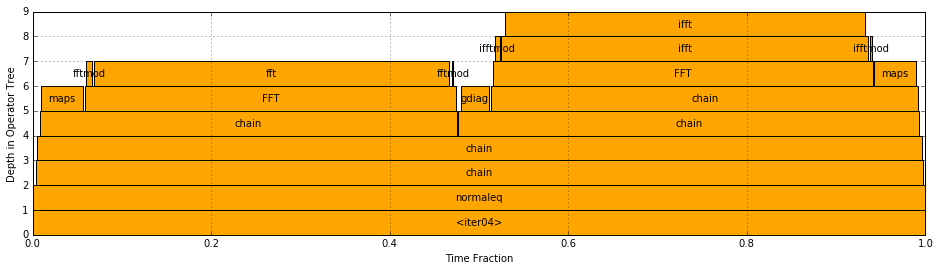

operation      time(%)
-----------  ---------
ifft               40%
fft                40%
maps                9%
unaccounted         6%
gdiag               3%
fftmod              1%
ifftmod             1%
FAIL <frozendict {'dims': 3, 'reg': 'tv', 'encodes': (512, 512, 512), 'traj': 'cart'}> list index out of range


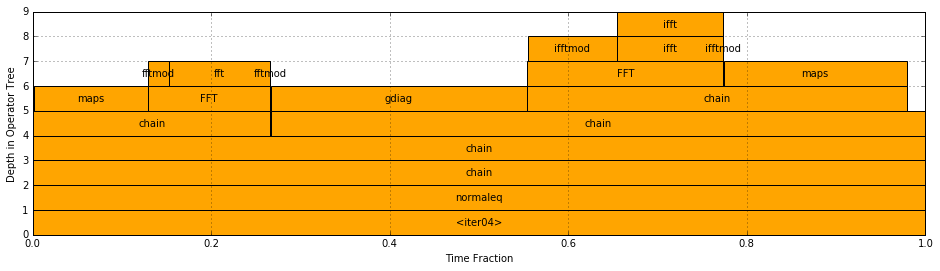

operation      time(%)
-----------  ---------
maps               33%
gdiag              29%
ifft               12%
fft                11%
ifftmod            10%
unaccounted         3%
fftmod              2%


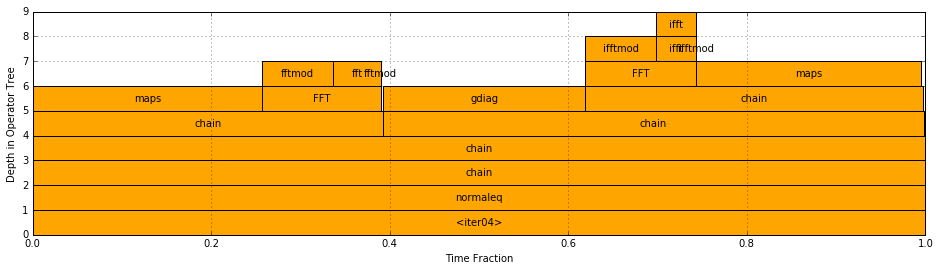

operation      time(%)
-----------  ---------
maps               51%
gdiag              23%
ifftmod             8%
fftmod              8%
fft                 5%
ifft                4%
unaccounted         1%


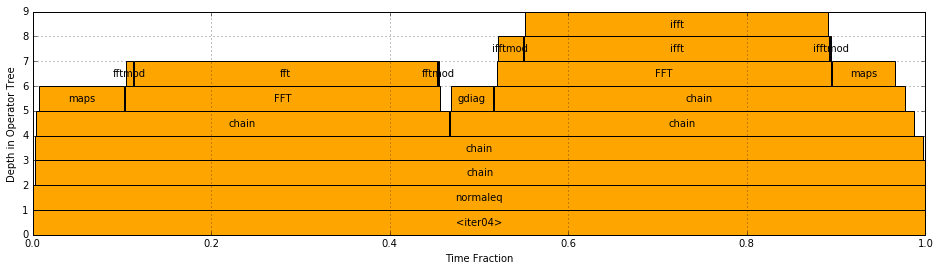

operation      time(%)
-----------  ---------
ifft               34%
fft                34%
maps               17%
unaccounted         7%
gdiag               5%
ifftmod             3%
fftmod              1%


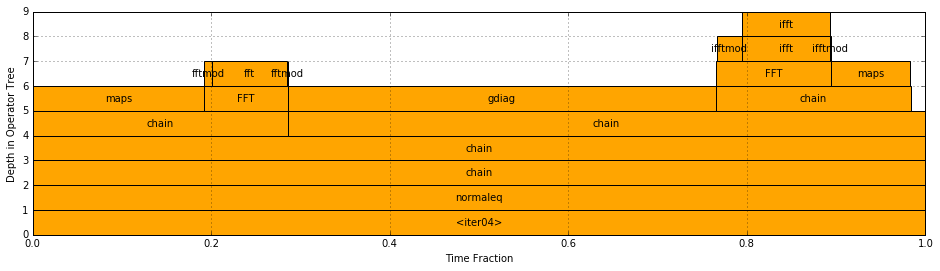

operation      time(%)
-----------  ---------
gdiag              48%
maps               28%
ifft               10%
fft                 8%
ifftmod             3%
unaccounted         2%
fftmod              1%


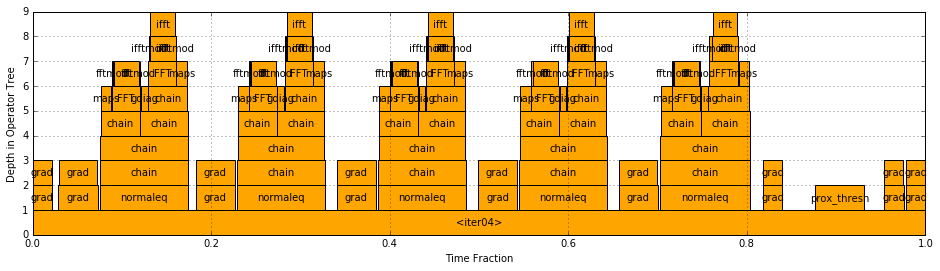

operation      time(%)
-----------  ---------
grad               30%
unaccounted        19%
fft                14%
ifft               14%
maps               12%
prox_thresh         6%
gdiag               4%
ifftmod             1%
fftmod              1%


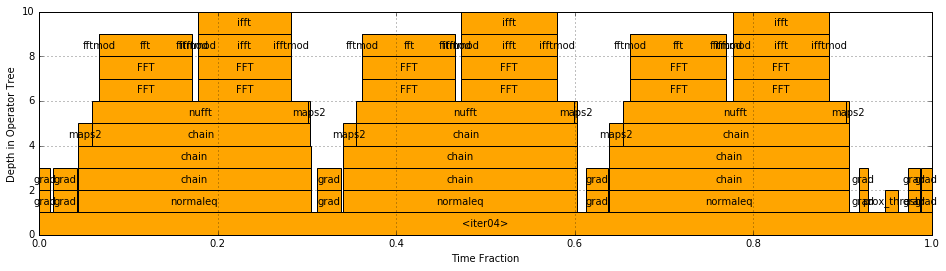

operation      time(%)
-----------  ---------
ifft               32%
fft                32%
unaccounted        17%
grad               13%
maps2               5%
prox_thresh         1%
fftmod              0%
ifftmod             0%


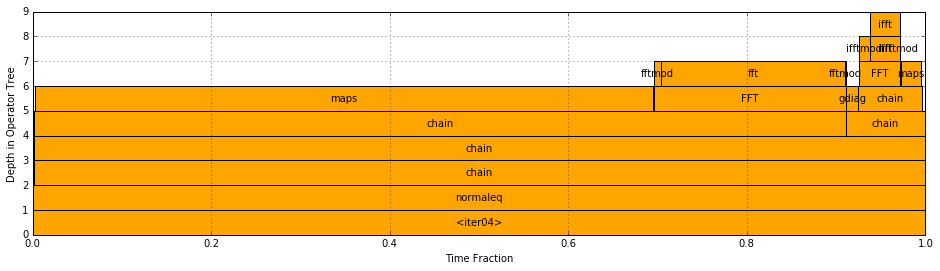

operation      time(%)
-----------  ---------
maps               72%
fft                21%
ifft                3%
gdiag               1%
ifftmod             1%
unaccounted         1%
fftmod              1%


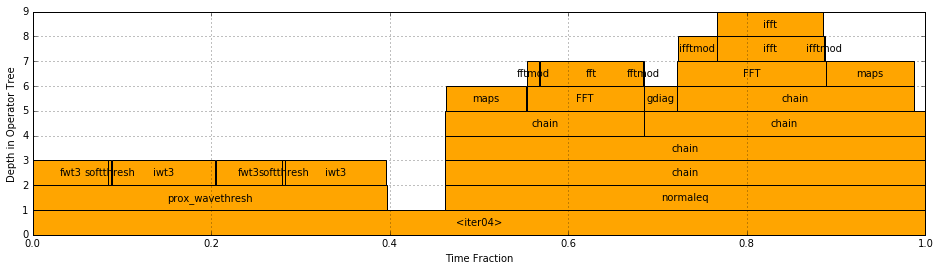

operation      time(%)
-----------  ---------
iwt3               23%
maps               19%
fwt3               16%
ifft               12%
fft                12%
unaccounted         9%
ifftmod             4%
gdiag               4%
fftmod              1%
softthresh          1%


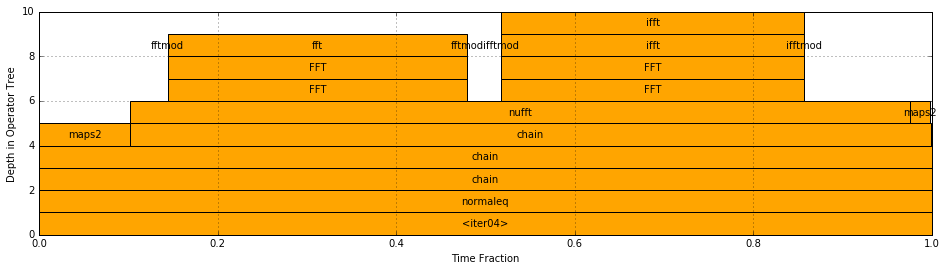

operation      time(%)
-----------  ---------
ifft               34%
fft                34%
unaccounted        20%
maps2              12%
ifftmod             0%
fftmod              0%


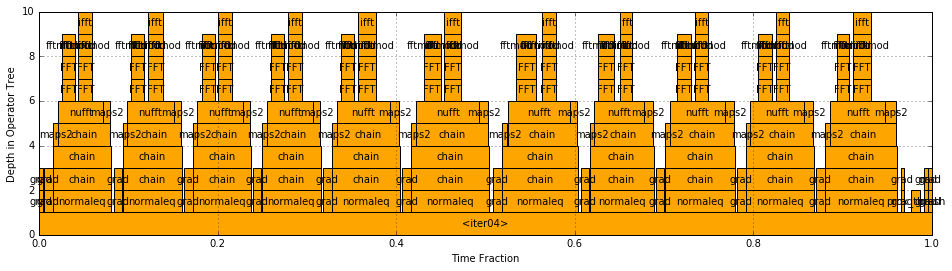

operation      time(%)
-----------  ---------
unaccounted        35%
ifft               18%
fft                18%
maps2              16%
grad               12%
prox_thresh         1%
ifftmod             0%
fftmod              0%


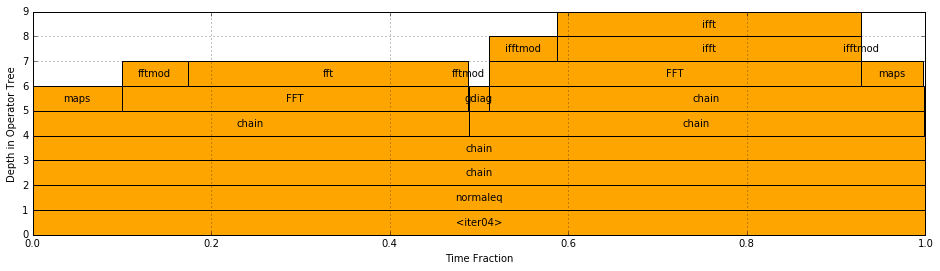

operation      time(%)
-----------  ---------
ifft               34%
fft                31%
maps               17%
ifftmod             8%
fftmod              7%
gdiag               2%
unaccounted         0%


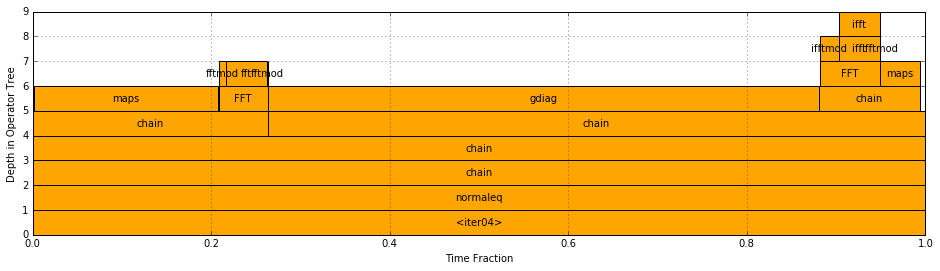

operation      time(%)
-----------  ---------
gdiag              62%
maps               25%
fft                 5%
ifft                5%
ifftmod             2%
unaccounted         1%
fftmod              1%


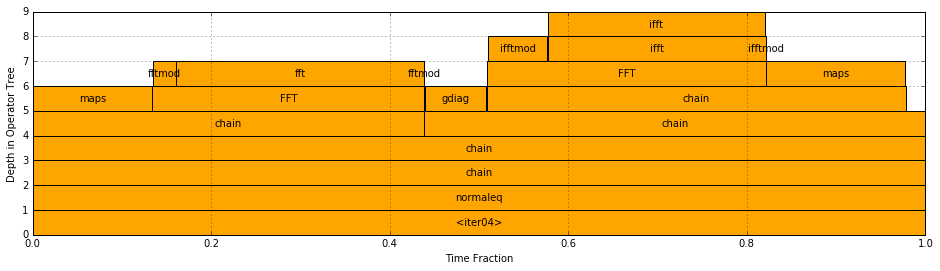

operation      time(%)
-----------  ---------
maps               29%
fft                28%
ifft               24%
gdiag               7%
ifftmod             7%
unaccounted         3%
fftmod              3%


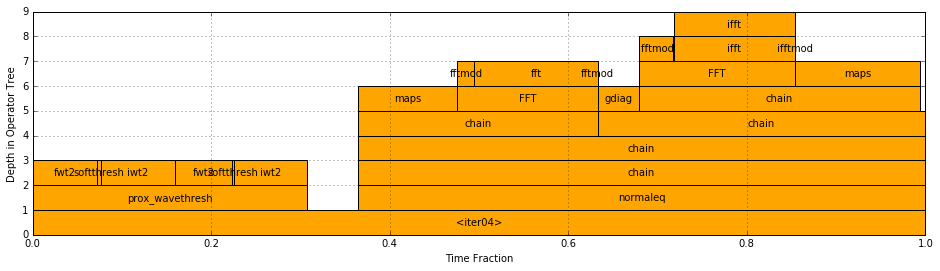

operation      time(%)
-----------  ---------
maps               25%
iwt2               16%
fft                14%
fwt2               14%
ifft               14%
unaccounted         7%
gdiag               5%
ifftmod             4%
fftmod              2%
softthresh          1%


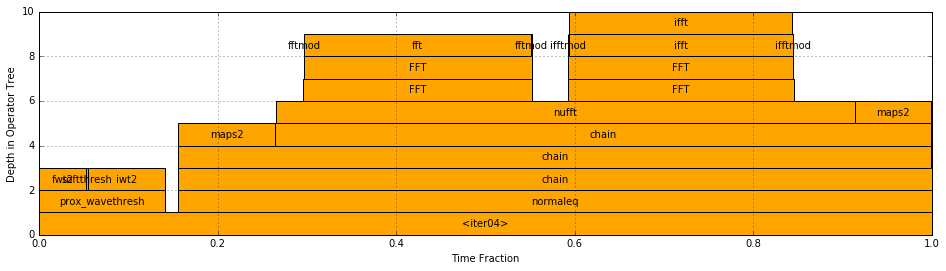

operation      time(%)
-----------  ---------
fft                25%
ifft               25%
maps2              19%
unaccounted        16%
iwt2                9%
fwt2                5%
softthresh          0%
fftmod              0%
ifftmod             0%


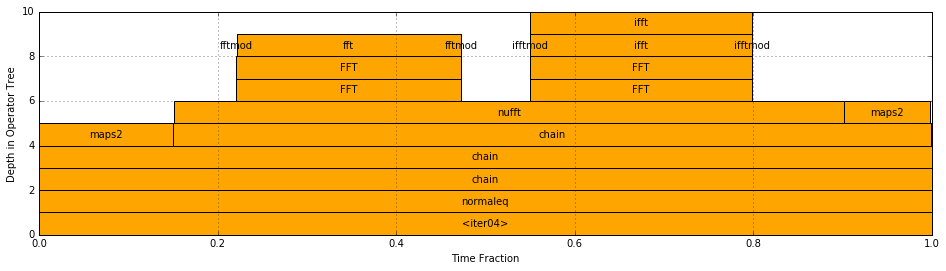

operation      time(%)
-----------  ---------
unaccounted        25%
fft                25%
ifft               25%
maps2              25%
fftmod              0%
ifftmod             0%


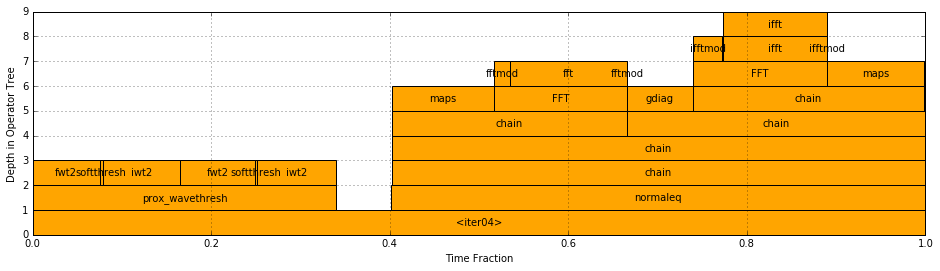

operation      time(%)
-----------  ---------
maps               22%
iwt2               17%
fwt2               16%
fft                13%
ifft               12%
gdiag               7%
unaccounted         6%
ifftmod             3%
fftmod              2%
softthresh          1%
FAIL <frozendict {'dims': 2, 'reg': 'l2', 'encodes': (32768, 4096), 'traj': 'radial'}> list index out of range


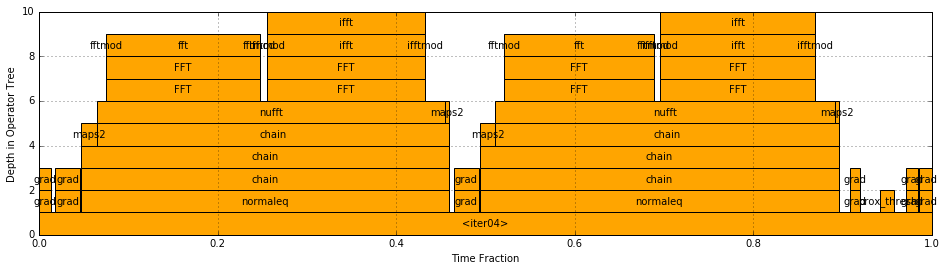

operation      time(%)
-----------  ---------
ifft               35%
fft                34%
unaccounted        14%
grad               11%
maps2               4%
prox_thresh         2%
fftmod              0%
ifftmod             0%


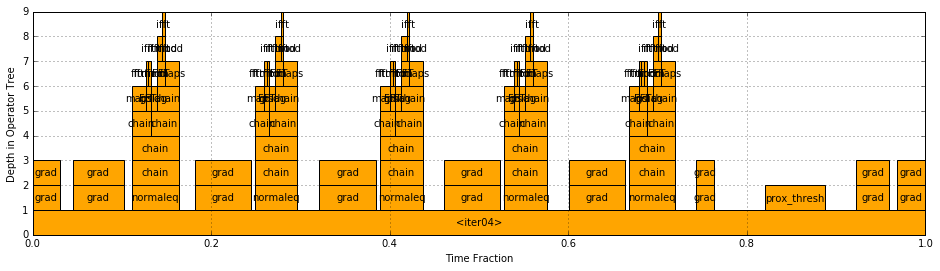

operation      time(%)
-----------  ---------
grad               43%
unaccounted        26%
maps               14%
prox_thresh         7%
gdiag               3%
ifftmod             3%
fftmod              2%
fft                 1%
ifft                1%


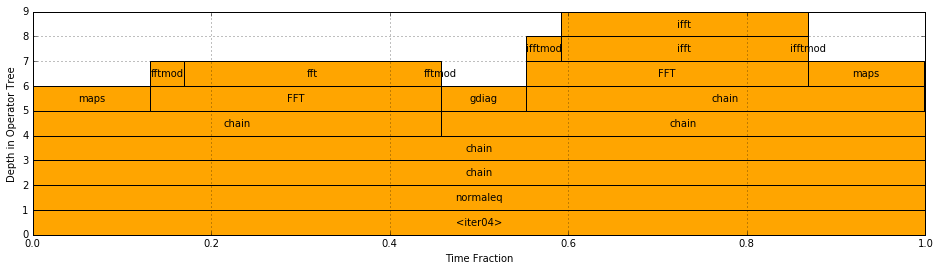

operation      time(%)
-----------  ---------
fft                29%
ifft               28%
maps               26%
gdiag               9%
ifftmod             4%
fftmod              4%
unaccounted         0%


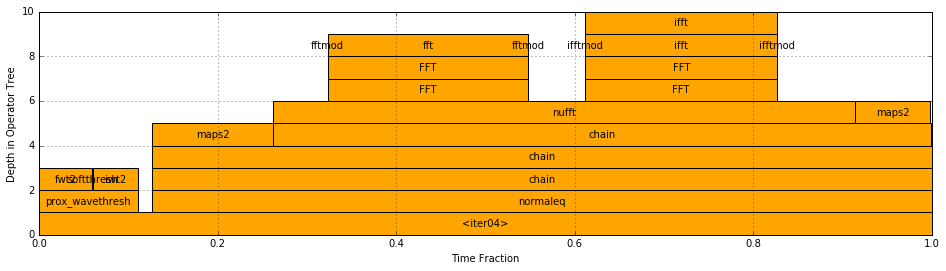

operation      time(%)
-----------  ---------
unaccounted        23%
fft                22%
maps2              22%
ifft               22%
fwt2                6%
iwt2                5%
softthresh          0%
fftmod              0%
ifftmod             0%


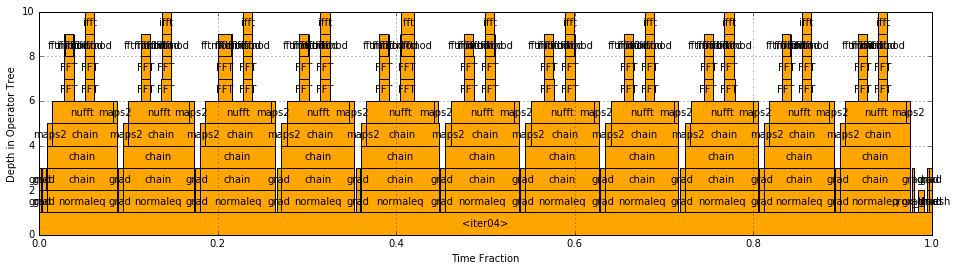

operation      time(%)
-----------  ---------
unaccounted        57%
maps2              12%
ifft               12%
fft                12%
grad                7%
prox_thresh         1%
fftmod              0%
ifftmod             0%


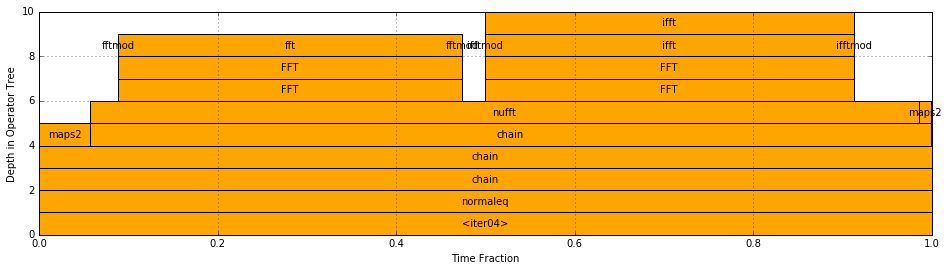

operation      time(%)
-----------  ---------
ifft               41%
fft                38%
unaccounted        13%
maps2               7%
ifftmod             0%
fftmod              0%


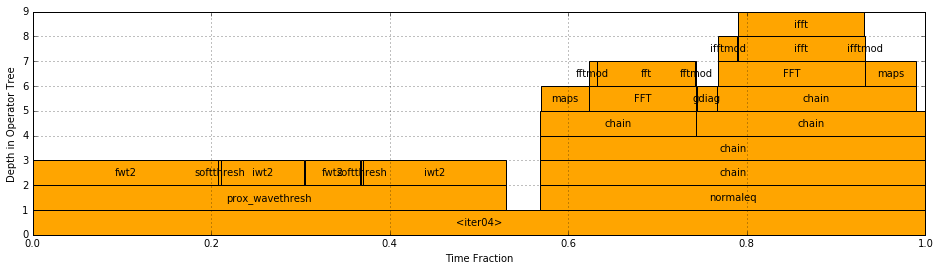

operation      time(%)
-----------  ---------
fwt2               27%
iwt2               25%
ifft               14%
maps               11%
fft                11%
unaccounted         6%
gdiag               2%
ifftmod             2%
fftmod              1%
softthresh          0%


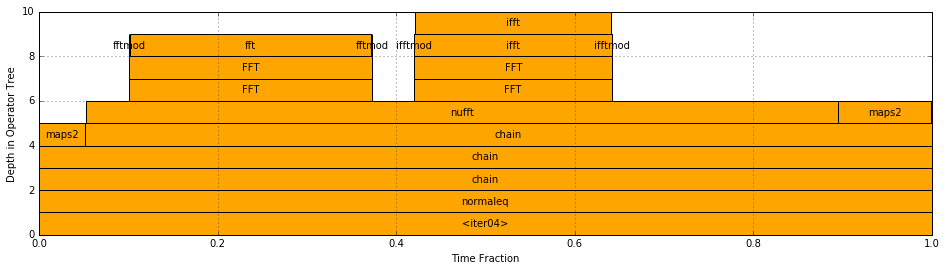

operation      time(%)
-----------  ---------
unaccounted        35%
fft                27%
ifft               22%
maps2              16%
fftmod              0%
ifftmod             0%


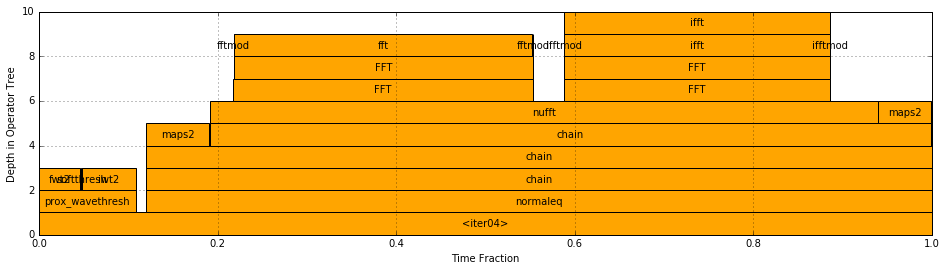

operation      time(%)
-----------  ---------
fft                33%
ifft               30%
unaccounted        13%
maps2              13%
iwt2                6%
fwt2                5%
softthresh          0%
fftmod              0%
ifftmod             0%


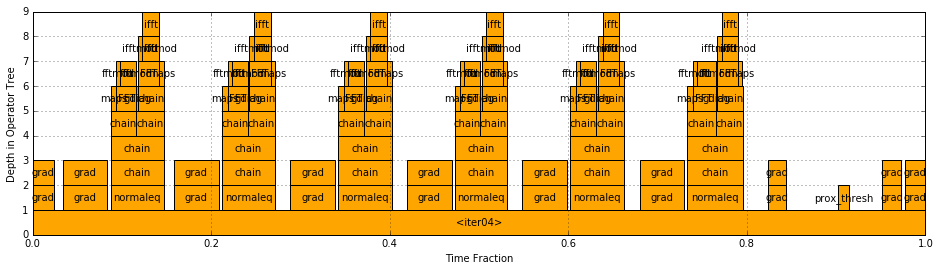

operation      time(%)
-----------  ---------
grad               39%
unaccounted        24%
ifft               11%
fft                11%
maps                7%
ifftmod             3%
fftmod              3%
prox_thresh         1%
gdiag               1%


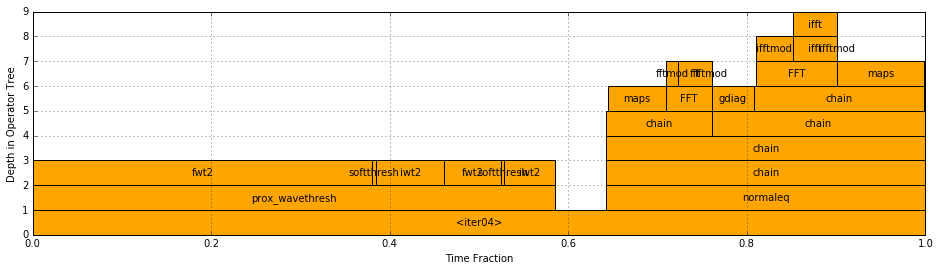

operation      time(%)
-----------  ---------
fwt2               44%
maps               16%
iwt2               13%
unaccounted         6%
ifft                5%
gdiag               5%
ifftmod             4%
fft                 4%
fftmod              1%
softthresh          1%


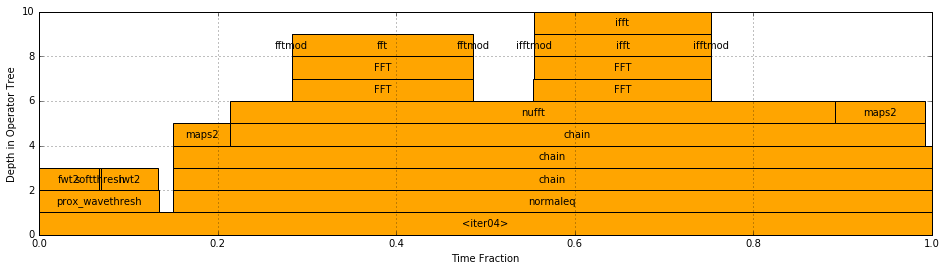

operation      time(%)
-----------  ---------
unaccounted        30%
fft                20%
ifft               20%
maps2              16%
fwt2                7%
iwt2                6%
softthresh          0%
fftmod              0%
ifftmod             0%


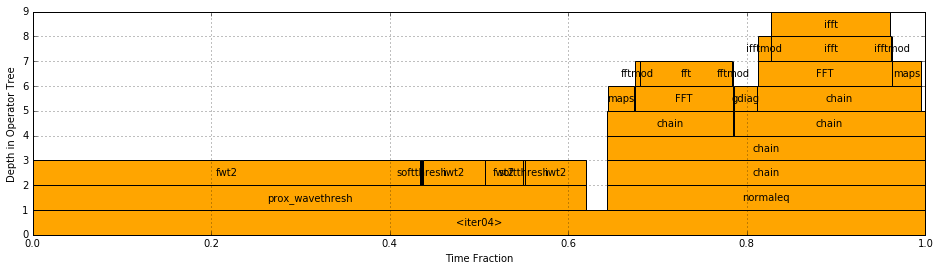

operation      time(%)
-----------  ---------
fwt2               48%
iwt2               14%
ifft               13%
fft                10%
maps                6%
unaccounted         4%
gdiag               2%
ifftmod             2%
fftmod              1%
softthresh          0%


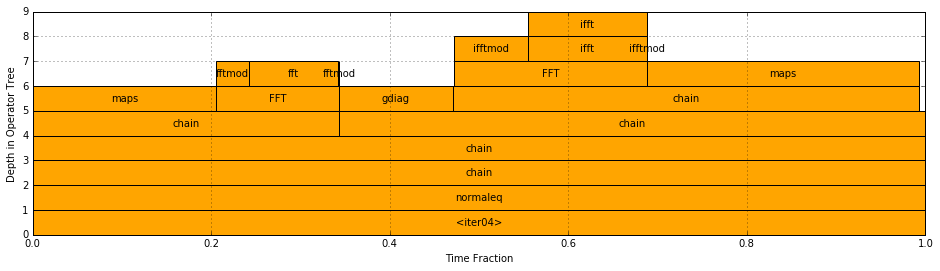

operation      time(%)
-----------  ---------
maps               51%
ifft               13%
gdiag              13%
fft                10%
ifftmod             8%
fftmod              4%
unaccounted         1%


In [4]:
def plot_events(data, params):
    fig = plt.figure(figsize=(16,4))
    #ax0 = fig.add_subplot(111)   
    times = defaultdict(float)
    duration = data.duration
    stack = [data]
    while stack:
        evt = stack.pop()
        stack.extend(evt.children)
        ymin, ymax = evt.depth-data.depth, evt.depth+1-data.depth
        xmin, xmax = (evt.start-data.start)/data.duration, (evt.end-data.start)/data.duration
        xy = xmin + (xmax-xmin)/2, ymin + (ymax-ymin)/2.0
        plt.axhspan(ymin, ymax, xmin, xmax, fc='orange', ec='k')
        plt.annotate(s=evt.name, xy=xy, color='k', va='center', ha='center')
        if not evt.children:
            times[evt.name] += evt.duration/data.duration
    title = "{dims}D {traj} acquisition with {reg} regularization; {nencodes:,} samples {encodes}; {time:,.0f} ms" \
                .format(time=duration*1e3, nencodes=np.prod(params['encodes']), **params) 
    display(HTML("<h2>%s</h2>" % title))
    plt.xlabel("Time Fraction")
    plt.ylabel("Depth in Operator Tree")
    plt.ylim(0)
    plt.grid()
    plt.show() 

    times["unaccounted"] = 1.0 - sum(times.values())
    times = sorted(times.items(), key=lambda (k,v): -v)
    print tabulate(times, headers="operation time(%)".split(), floatfmt=".0%")
    
for i, (params, run) in enumerate(data.items()):
    try:
        fractions = plot_events(run[4], params)
    except (IndexError, ValueError) as e:
        print "FAIL", params, e